# 0. 준비작업

In [ ]:
!pip install catboost
!pip install interpret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.6 MB 27.7 MB/s 
     |████████████████████████████████| 569 kB 63.3 MB/s 
     |████████████████████████████████| 756 kB 54.4 MB/s 
     |████████████████████████████████| 275 kB 69.2 MB/s 
     |████████████████████████████████| 3.6 MB 58.3 MB/s 
     |████████████████████████████████| 5.8 MB 54.1 MB/s 
     |████████████████████████████████| 9.9 MB 65.5 MB/s 
     |████████████████████████████████| 281 kB 67.0 MB/s 
     |████████████████████████████████| 251 kB 52.3 MB/s 
     |████████████████████████████████| 1.6 MB 59.1 MB/s 
     |████████████████████████████████| 76 kB 7.0 MB/s 
     |████████████████████████████████| 357 kB 27.9 MB/s 
     |████████████████████████████████| 52 kB 1.5 

In [ ]:
# 라이브러리 불러들이기

import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
import lightgbm
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from interpret.glassbox import ExplainableBoostingClassifier

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering
from sklearn.cluster import Birch
from sklearn.cluster import MeanShift
from sklearn.metrics import silhouette_samples, silhouette_score

from google.colab import drive
drive.mount('/content/drive')
import warnings
warnings.filterwarnings('ignore')

Mounted at /content/drive


In [ ]:
# 변수 정의

file_path = '/content/drive/MyDrive/SNC/data/make_data_final'
columns_list = ['NO', 'FR', 'PC', 'CP', 'WT', 'ZC', 'AP', 'FF', 'BF', 'MD', 'U0', 'U1', 'U2', 'U3', 'U4', 'U5', 'D0', 'D1', 'D2', 'D3', 'D4', 'D5', 'FRAm', 'drop']

In [ ]:
# 파일 list 생성

list_dir = os.listdir(file_path)

In [ ]:
# 데이터 불러오기 + 데이터 프레임 변환(TimeOut -> NAN)
# A는 1~27(A5 제외), AA는 1~19 (AA20 제외), AAA는 1~60 (AAA96 제외)

files = []

for i in list_dir:
  data = pd.read_csv('{}/{}'.format(file_path, i), dtype='str')
  data.columns = columns_list
  for j in columns_list:
    data[j] = data[j].str.strip()
    data.loc[data[j] == 'TimeOut', j] = np.nan
  data.drop([columns_list[-1], 'FR','PC', 'NO', 'FRAm'], axis = 1, inplace=True)
  files.append(data)

# 1. 데이터 1차 가공

> ## 1.1 결측치 대체 & 변수타입 변경

In [ ]:
 # nan 위치 확인

for i in range(len(files)):
  for j in files[i].columns:
    if files[i][j].isna().sum() != 0:
      print(list_dir[i], j) 

AA17.log ZC
AA17.log FF
AA17.log MD
AA17.log U4
AA17.log D1
AA17.log D2
AA17.log D4
AA17.log D5
AAA54.log MD
AAA32.log FF
AAA13.log D4
AAA57.log FF


In [ ]:
# nan 대치

for i in files:
  i.fillna(method='pad', inplace=True)
  i.fillna(method='bfill', inplace=True)

In [ ]:
 # nan 위치 확인

for i in range(len(files)):
  for j in files[i].columns:
    if files[i][j].isna().sum() != 0:
      print(list_dir[i], j) 

In [ ]:
# 데이터 타입 변경

for i in range(len(files)):
  for j in files[i].columns:
    files[i][j] = files[i][j].astype('float')

> ## 1.2 시간 가중치

In [ ]:
# 변수 정의

weight_method = {'CP': 'mean', 'WT': 'mode', 'ZC': 'mode', 'AP': 'mode', 'FF': 'mean', 'BF': 'mean', 'MD': 'mode', 'U0': 'mode', 'U1': 'mode', 'U2': 'mode', 'U3': 'mode', 'U4': 'mode', 'U5': 'mode', 'D0': 'mode', 'D1': 'mode', 'D2': 'mode', 'D3': 'mode', 'D4': 'mode', 'D5': 'mode'}
b0 = -2.197224577
b1 = 0.1248421567

In [ ]:
# 시간 가중치 함수 정의

def cross_weight(df, column, weight_method, weight):
  if weight_method[column] == 'mean':
    mean_value = df[column].mean()
    return mean_value - weight*(mean_value - df[column])
    
  elif weight_method[column] == 'mode':
    if len(df[column].mode()) > 1:
      mode_value = float(df[column].mode().iloc[-1])
      return mode_value - weight*(mode_value - df[column])  
    else:
      mode_value = float(df[column].mode())
      return mode_value - weight*(mode_value - df[column])  

In [ ]:
# 시간 가중치 적용

for i in range(len(files)):
  for j in weight_method.keys():
    t = np.arange(0, files[i][j].count(), 1)
    weight = np.round(1 / (1+ np.exp(-(b0+b1*t))), 2) # 0초 -> 0.1, 60초 -> 1, logistic 함수

    files[i][j] = cross_weight(files[i], j, weight_method, weight)

> ## 1.3 데이터 대표 값 대체

In [ ]:
# 새로운 df에 컬럼정리

df = pd.DataFrame()

for i in range(len(files)):
  data = files[i] 

  df.loc[i, 'sample_name']=list_dir[i].split('.')[0]
  df.loc[i,'CP_std']=data.loc[:,'CP'].std().round(2) # A, B 초음파 센서의 주파수의 안정성
  df.loc[i,'CP_abs_mean']= abs(data.loc[:,'CP']).mean().round(2) # A, B 초음파 센서의 주파수의 적절성
  df.loc[i,'ZC_mode']=data.loc[:,'ZC'].mode().iloc[-1].round(2) # 생성과정중 위치(각도&거리)의 오차 & A 초음파 센서 진폭의 적절성
  df.loc[i,'AP_mode']=data.loc[:,'AP'].mode().iloc[-1].round(2) # A 초음파센서 진폭의 적절성
  df.loc[i,'FF_mean']=data.loc[:,'FF'].mean().round(2) # A 초음파센서 주파수의 적절성(약 2000)
  df.loc[i,'FF_std']=data.loc[:,'FF'].std().round(2) # A 초음파센서의 주파수의 안정성
  df.loc[i,'BF_mean']=data.loc[:,'BF'].mean().round(2) # B 초음파센서 주파수의 적절성(약 2000)
  df.loc[i,'BF_std']=data.loc[:,'BF'].std().round(2)  # B 초음파센서의 주파수의 안정성
  df.loc[i,'BF_FF_mean']=(data.loc[:,'BF']-data.loc[:,'FF']).mean().round(2) # 양 초음파센서의 동일성
  df.loc[i,'MD_mode']= data.loc[:,'MD'].mode().iloc[-1].round(2) # A 초음파센서 주파수의 적절성(약 1530)
  df.loc[i,'U4_D4_mean']=(data.loc[:,'U4']+data.loc[:,'D4']).mean().round(2) # A 초음파센서 진폭의 적절성(130이 정상)
  df.loc[i,'U4_D4_std']=(data.loc[:,'U4']+data.loc[:,'D4']).std().round(2) # A 초음파센서 진폭의 안정성

In [ ]:
# 불량품 분류

df['error'] = 0
df.loc[df['AP_mode'] == 250, 'error'] = 1

In [ ]:
df.to_csv('e_error.csv')

# 2. EDA

In [ ]:
# 이상치 함수 정의

def outliers_iqr(dt, col):
    quartile_1, quartile_3 = np.percentile(dt[col], [25, 75])
    iqr = quartile_3 - quartile_1
    lower_whis = quartile_1 - (iqr * 1.5)
    upper_whis = quartile_3 + (iqr * 1.5)
    outliers = dt[(dt[col] > upper_whis) | (dt[col] < lower_whis)]
    return outliers[['sample_name', col, 'error']]

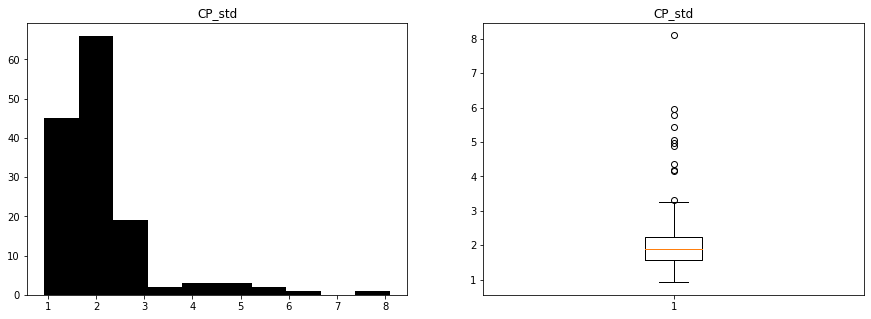

평균: 2.116267605633803
중앙값: 1.895
최빈값: [1.37, 1.53, 1.56, 1.57, 1.66, 1.91, 1.94, 2.06, 2.09, 2.12]
최대값: 8.1
최소값: 0.92
표준편차: 1.0409383445234357
    sample_name  CP_std  error
8          AA16    4.36      1
15         AA14    4.19      1
17         AA17    3.33      1
34          AA8    4.16      1
42         AA15    5.07      1
56          AA7    4.89      1
71          AA6    5.80      1
78         AA12    5.45      1
87          AA5    5.95      1
95         AA13    4.96      1
117         AA4    8.10      1



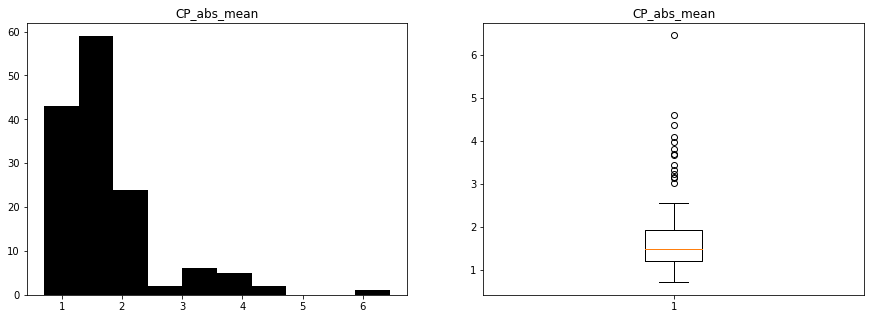

평균: 1.7219718309859153
중앙값: 1.495
최빈값: [1.42, 1.63]
최대값: 6.45
최소값: 0.71
표준편차: 0.8513045803721375
    sample_name  CP_abs_mean  error
8          AA16         3.16      1
15         AA14         3.13      1
34          AA8         3.23      1
42         AA15         3.69      1
56          AA7         3.82      1
71          AA6         3.97      1
73        AAA84         3.01      0
78         AA12         4.36      1
87          AA5         4.59      1
95         AA13         4.10      1
106         AA9         3.44      1
117         AA4         6.45      1
121       AAA64         3.67      0
124        AAA5         3.32      0



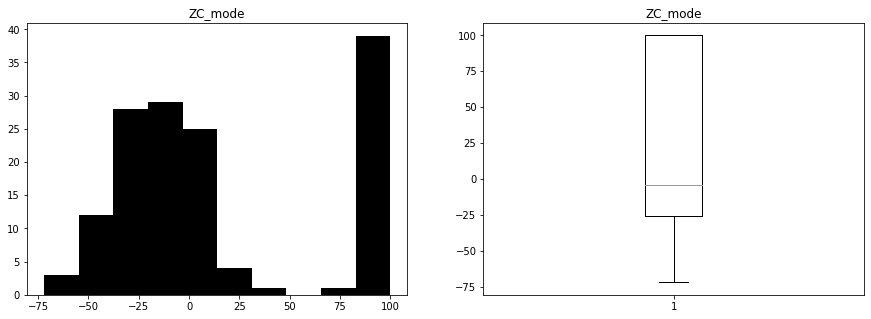

평균: 15.845070422535212
중앙값: -4.0
최빈값: [100.0]
최대값: 100.0
최소값: -72.0
표준편차: 55.09943246346939
Empty DataFrame
Columns: [sample_name, ZC_mode, error]
Index: []



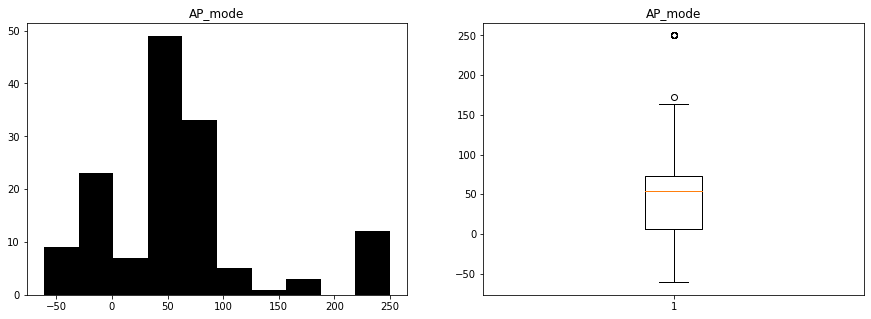

평균: 59.359154929577464
중앙값: 54.0
최빈값: [250.0]
최대값: 250.0
최소값: -61.0
표준편차: 72.08253165291545
    sample_name  AP_mode  error
8          AA16    250.0      1
15         AA14    250.0      1
17         AA17    250.0      1
34          AA8    250.0      1
42         AA15    250.0      1
56          AA7    250.0      1
71          AA6    250.0      1
78         AA12    250.0      1
87          AA5    250.0      1
95         AA13    250.0      1
106         AA9    250.0      1
117         AA4    250.0      1
124        AAA5    173.0      0



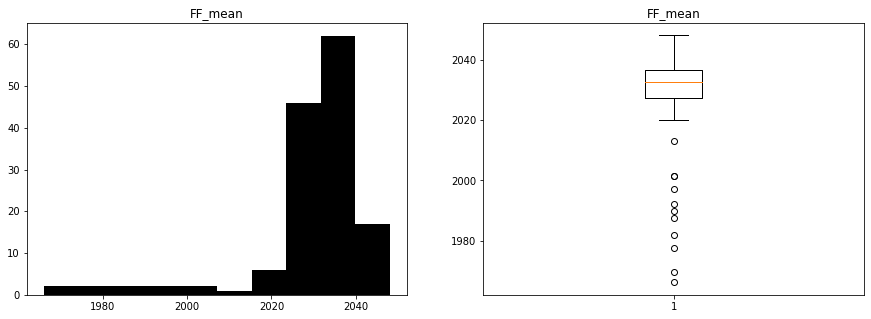

평균: 2029.761126760563
중앙값: 2032.76
최빈값: [2001.27, 2033.74, 2034.82]
최대값: 2048.09
최소값: 1966.12
표준편차: 13.790001059385764
    sample_name  FF_mean  error
8          AA16  1977.40      1
9           A14  2013.00      0
15         AA14  2001.27      1
34          AA8  1987.49      1
42         AA15  1981.91      1
56          AA7  1989.80      1
71          AA6  1969.47      1
78         AA12  1992.12      1
87          AA5  1997.06      1
95         AA13  1966.12      1
117         AA4  2001.27      1



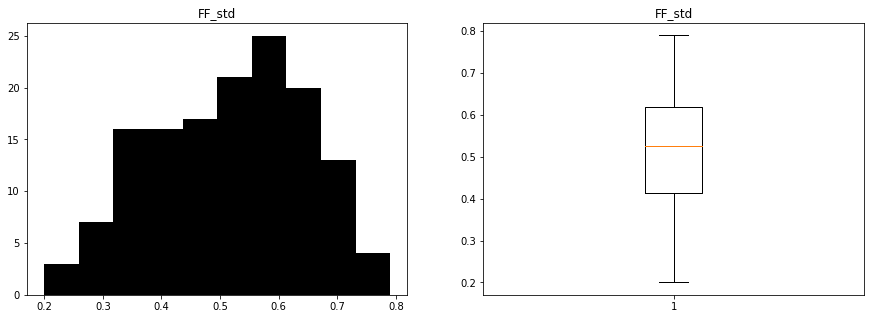

평균: 0.5180281690140845
중앙값: 0.525
최빈값: [0.52]
최대값: 0.79
최소값: 0.2
표준편차: 0.13518172395578915
Empty DataFrame
Columns: [sample_name, FF_std, error]
Index: []



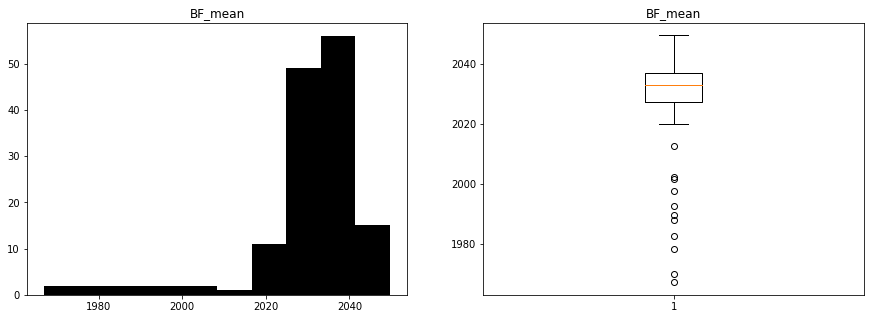

평균: 2030.0346478873241
중앙값: 2033.12
최빈값: [2037.6]
최대값: 2049.69
최소값: 1966.97
표준편차: 13.755116735235655
    sample_name  BF_mean  error
8          AA16  1978.01      1
9           A14  2012.76      0
15         AA14  2001.70      1
34          AA8  1987.79      1
42         AA15  1982.58      1
56          AA7  1989.49      1
71          AA6  1969.95      1
78         AA12  1992.55      1
87          AA5  1997.67      1
95         AA13  1966.97      1
117         AA4  2002.17      1



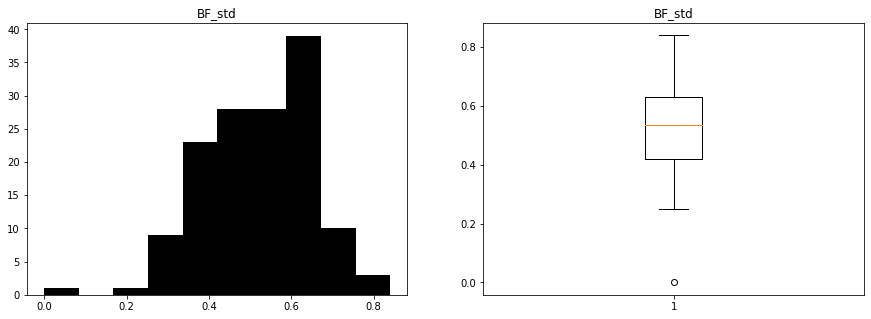

평균: 0.5227464788732394
중앙값: 0.535
최빈값: [0.57, 0.64, 0.66]
최대값: 0.84
최소값: 0.0
표준편차: 0.13017797073824708
    sample_name  BF_std  error
111       AAA24     0.0      0



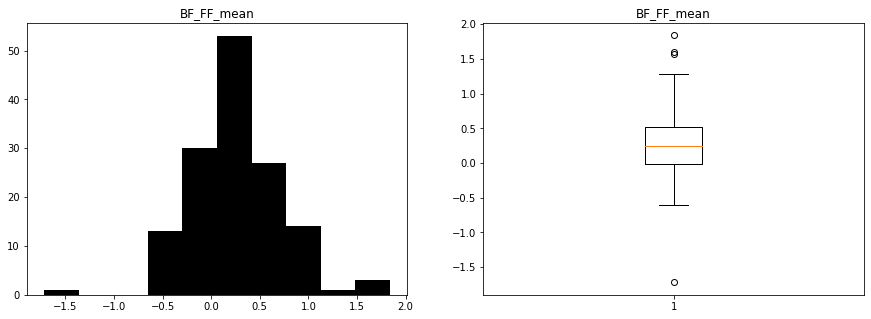

평균: 0.2731690140845071
중앙값: 0.24
최빈값: [-0.31, 0.07, 0.24, 0.33, 0.35]
최대값: 1.84
최소값: -1.72
표준편차: 0.4641951315641036
   sample_name  BF_FF_mean  error
5         AA18        1.60      0
17        AA17        1.84      1
30       AAA22        1.57      0
62         A19       -1.72      0



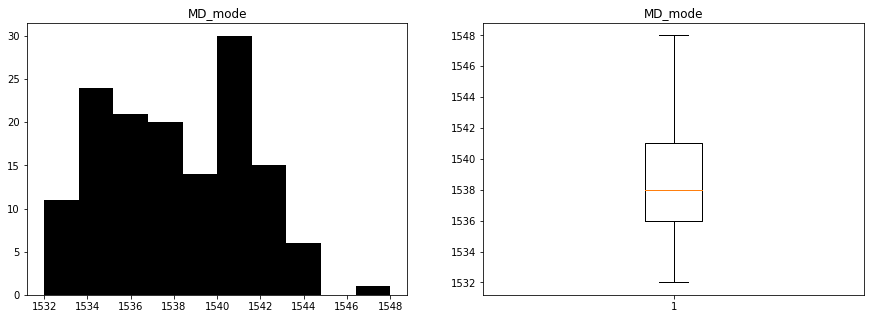

평균: 1538.0352112676057
중앙값: 1538.0
최빈값: [1536.0]
최대값: 1548.0
최소값: 1532.0
표준편차: 3.301433112051086
Empty DataFrame
Columns: [sample_name, MD_mode, error]
Index: []



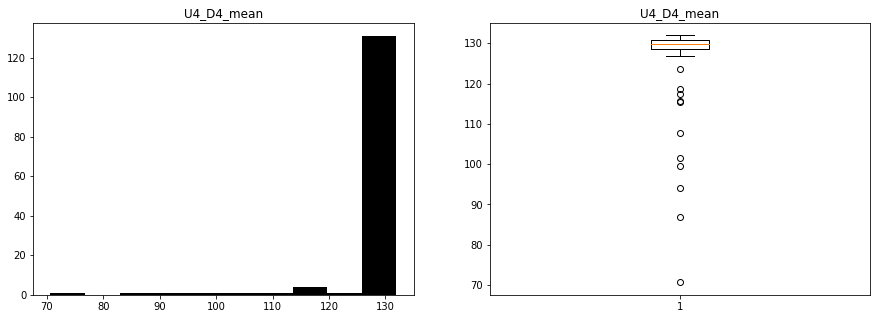

평균: 127.89190140845072
중앙값: 129.75
최빈값: [128.46, 128.55, 129.66]
최대값: 131.96
최소값: 70.62
표준편차: 8.080394707469967
    sample_name  U4_D4_mean  error
8          AA16      107.66      1
17         AA17      115.70      1
34          AA8       93.99      1
42         AA15      123.63      1
56          AA7      118.61      1
71          AA6      115.34      1
78         AA12      117.47      1
87          AA5      101.61      1
95         AA13       86.84      1
106         AA9       70.62      1
117         AA4       99.59      1



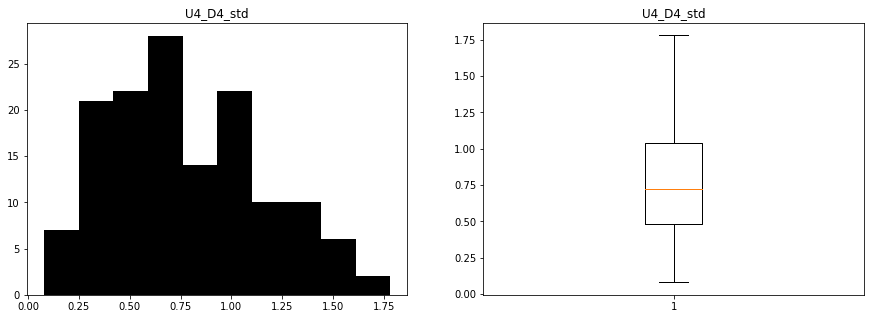

평균: 0.780281690140845
중앙값: 0.725
최빈값: [0.56, 0.7, 0.73]
최대값: 1.78
최소값: 0.08
표준편차: 0.3775057064280958
Empty DataFrame
Columns: [sample_name, U4_D4_std, error]
Index: []



In [ ]:
# 히스토그램 & 박스 플롯

for i in df.columns:
  if i == 'sample_name' or i == 'error': continue   

  plt.figure(figsize=(15, 5))
  plt.subplot(1, 2, 1)
  plt.title('{}'.format(i))
  plt.hist('{}'.format(i), color='k', data = df)

  plt.subplot(1, 2, 2)
  plt.title('{}'.format(i))
  plt.boxplot(df['{}'.format(i)], whis=1.5)  
  plt.show()
  
  print("평균: {}".format((df['{}'.format(i)].mean())))
  print("중앙값: {}".format((df['{}'.format(i)].median())))
  print("최빈값: {}".format((list(df['{}'.format(i)].mode()))))
  print("최대값: {}".format((df['{}'.format(i)].max())))
  print("최소값: {}".format((df['{}'.format(i)].min())))
  print("표준편차: {}".format((df['{}'.format(i)].std())))
  print(outliers_iqr(df,'{}'.format(i)), end='\n\n')

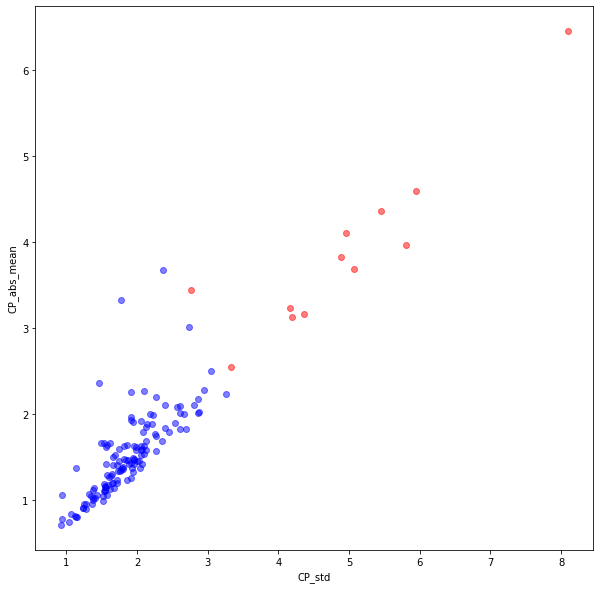

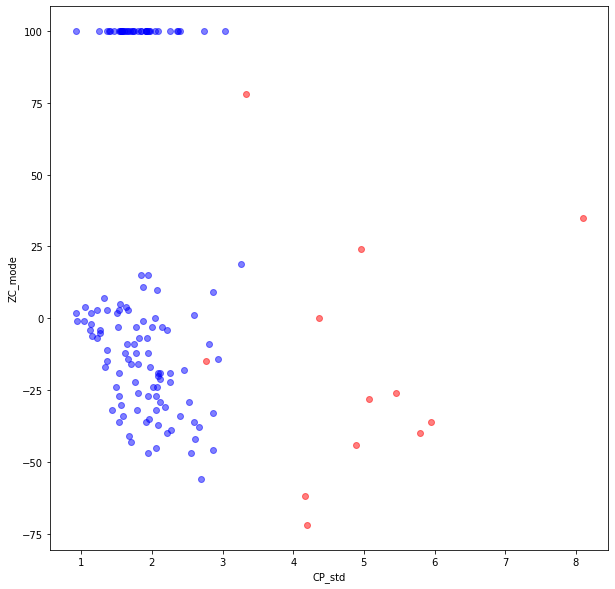

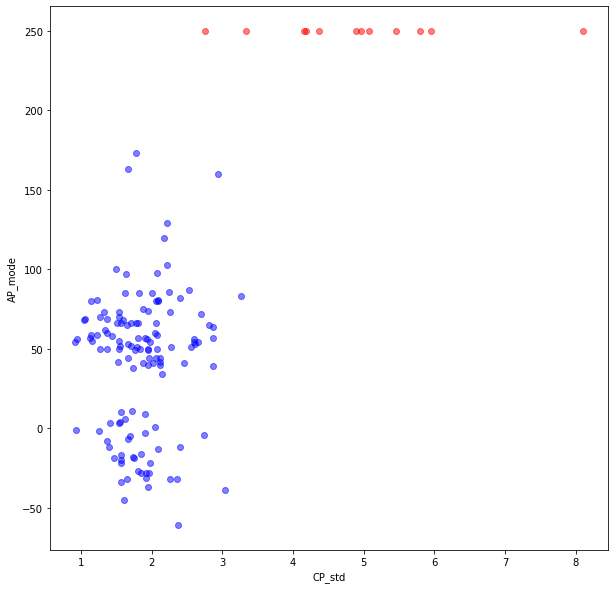

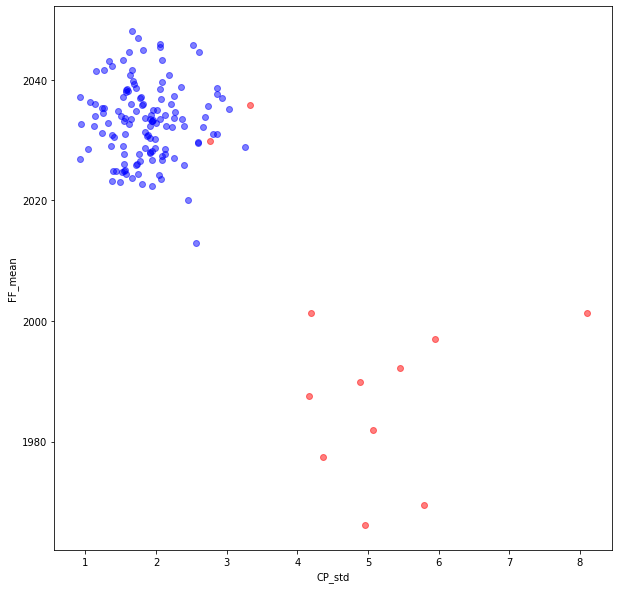

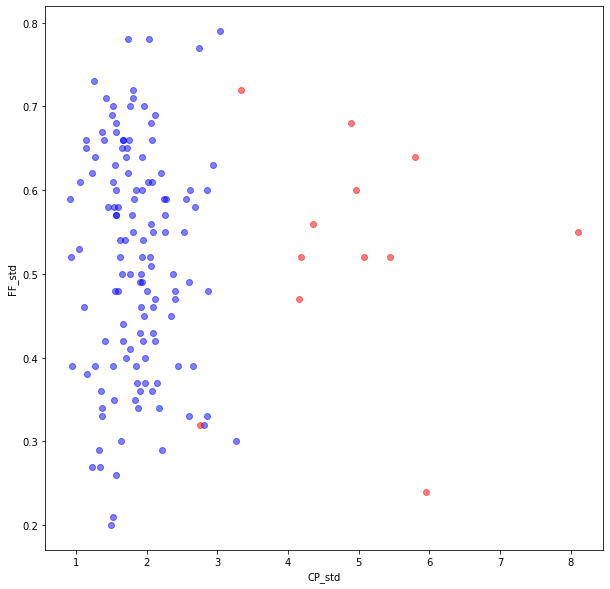

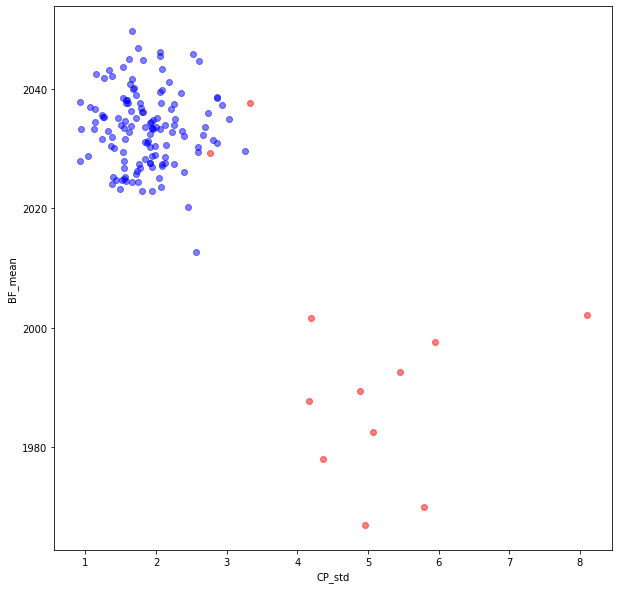

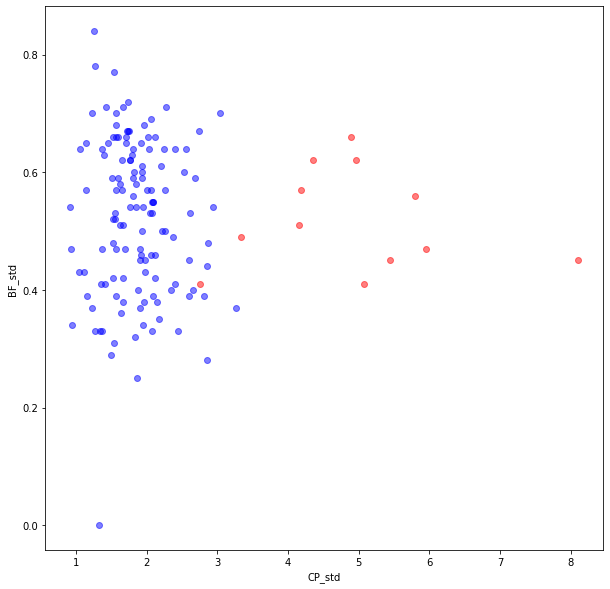

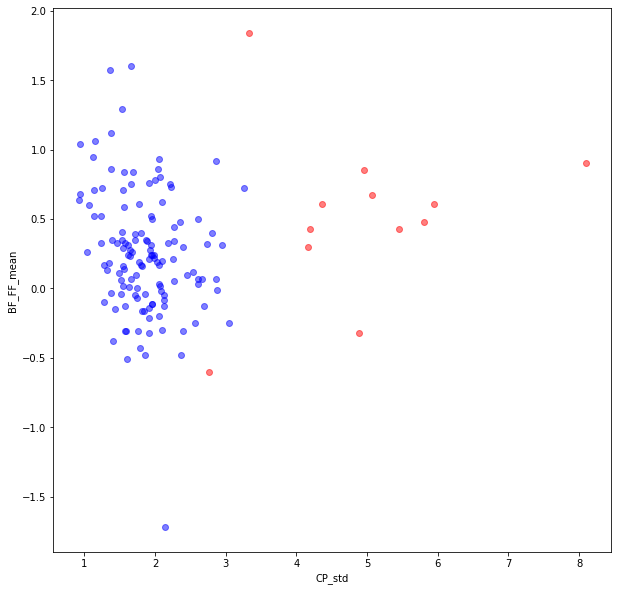

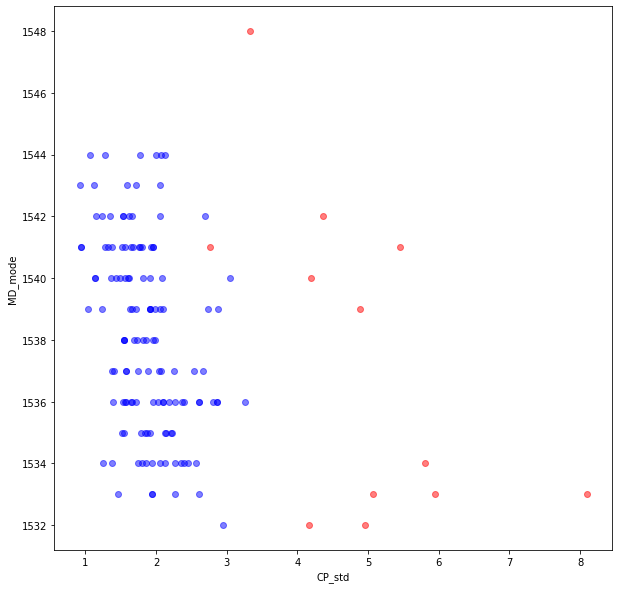

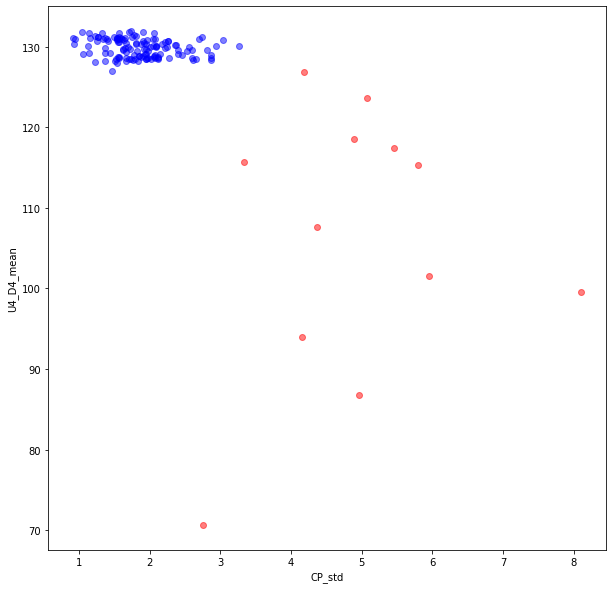

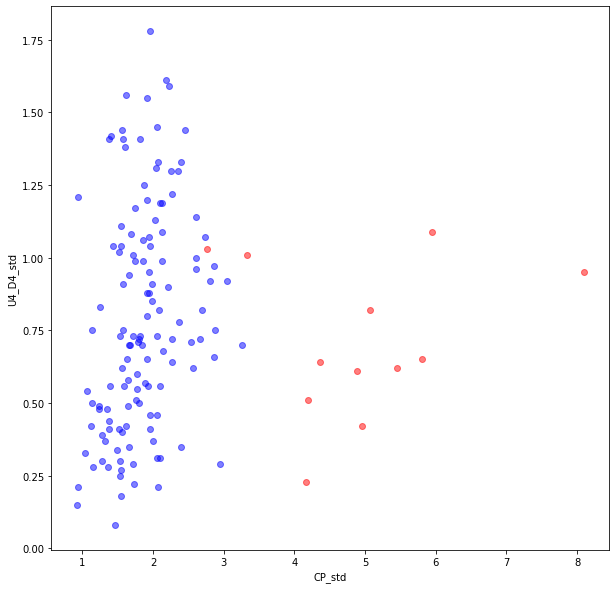

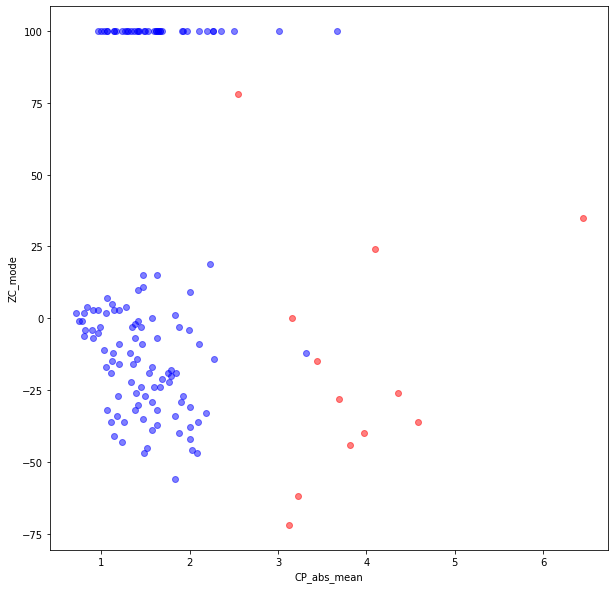

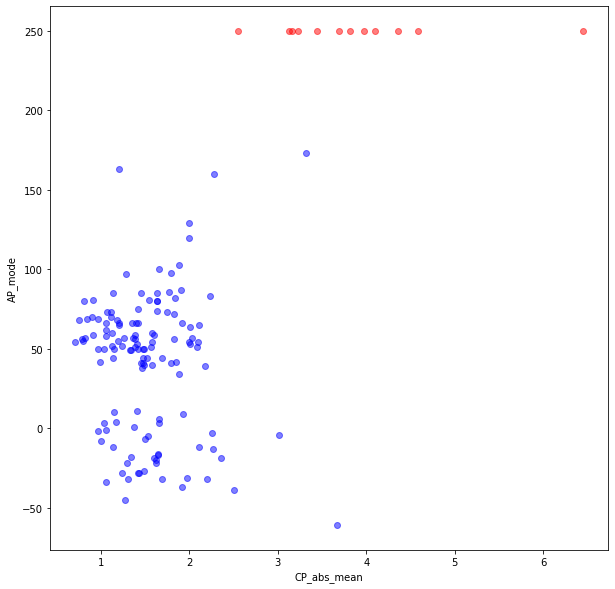

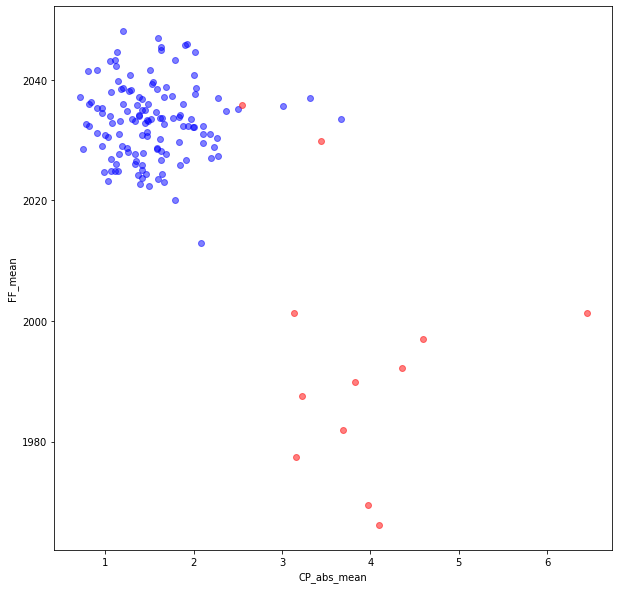

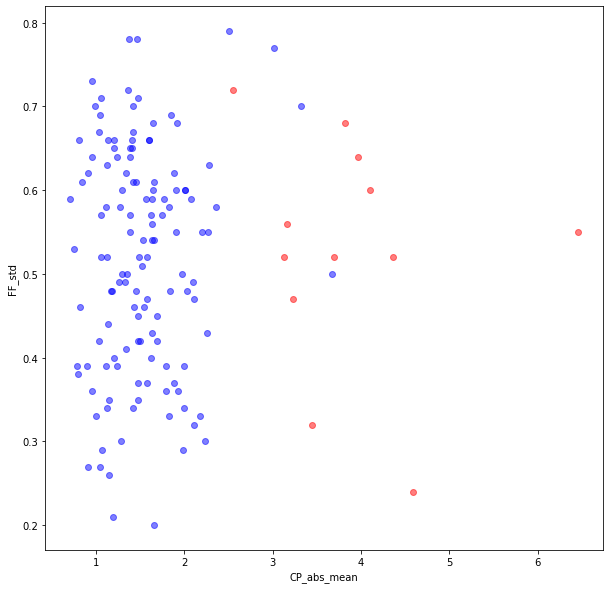

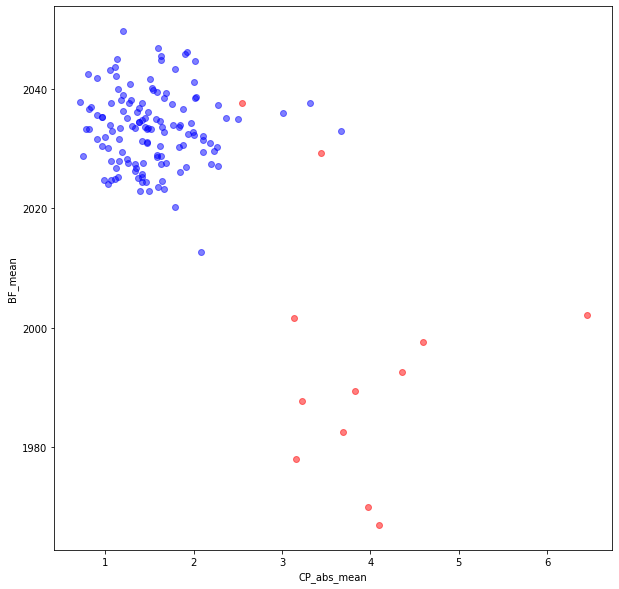

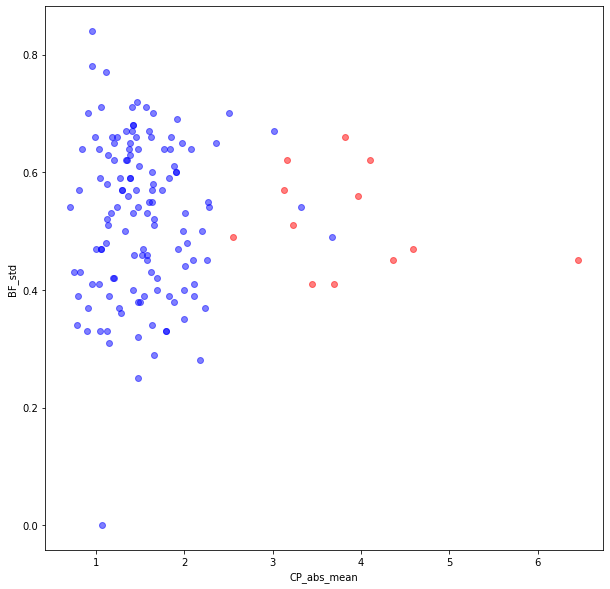

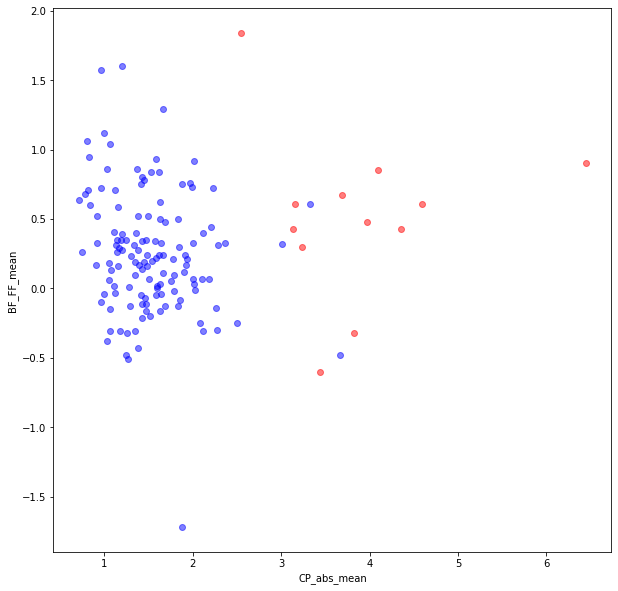

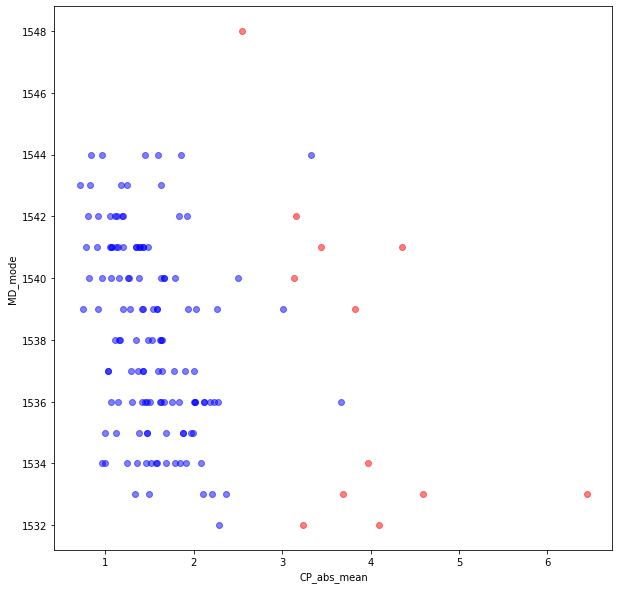

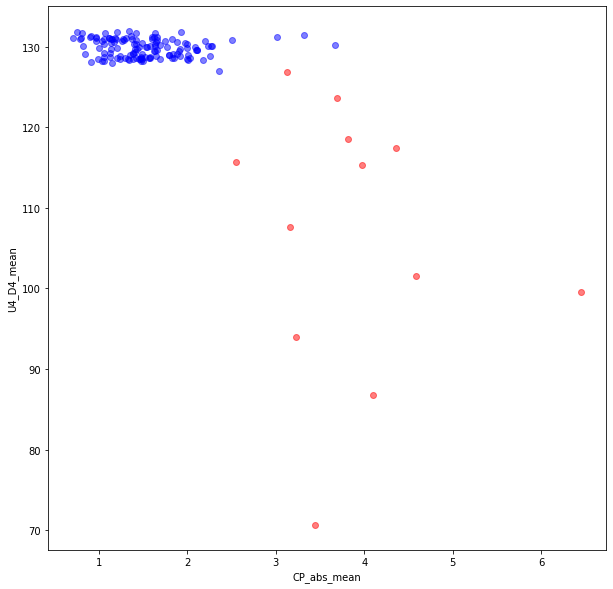

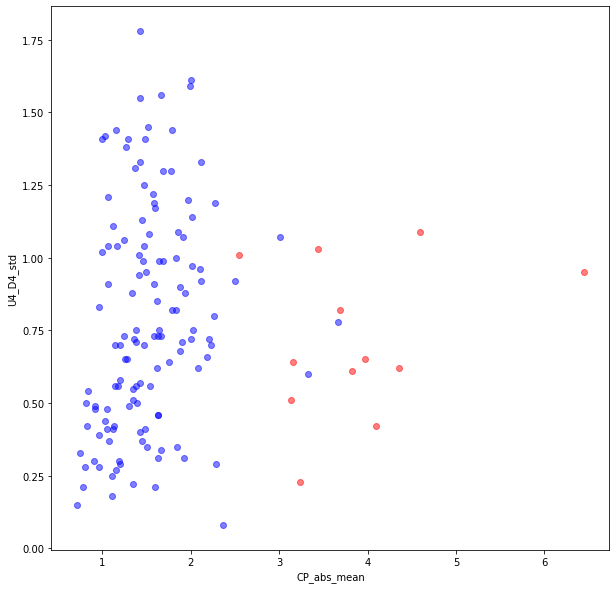

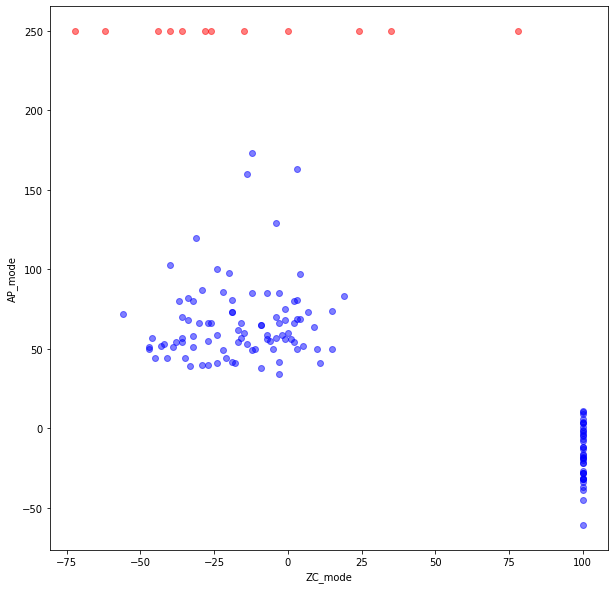

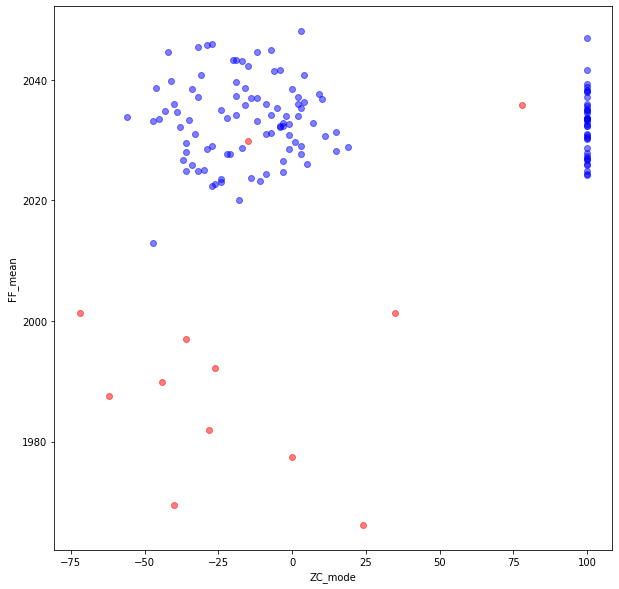

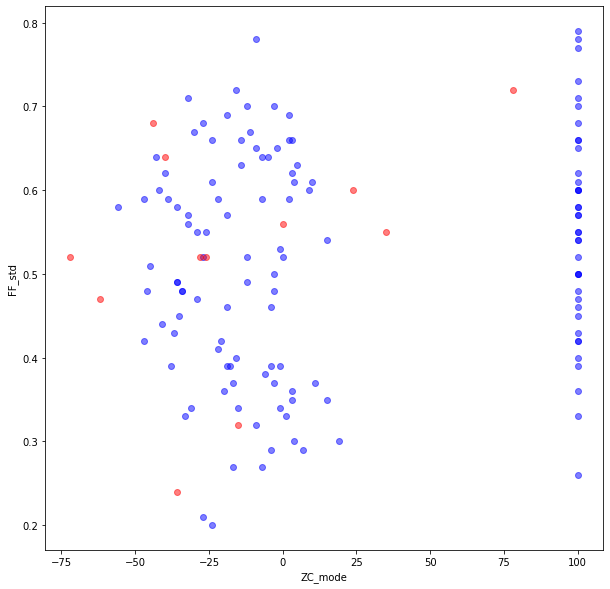

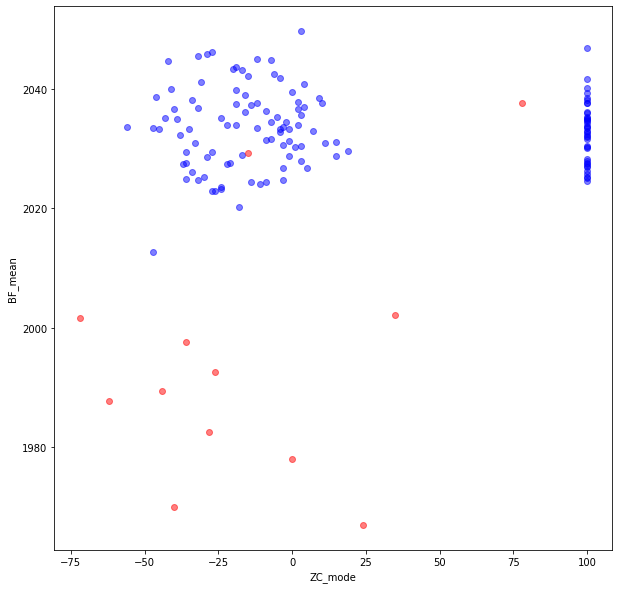

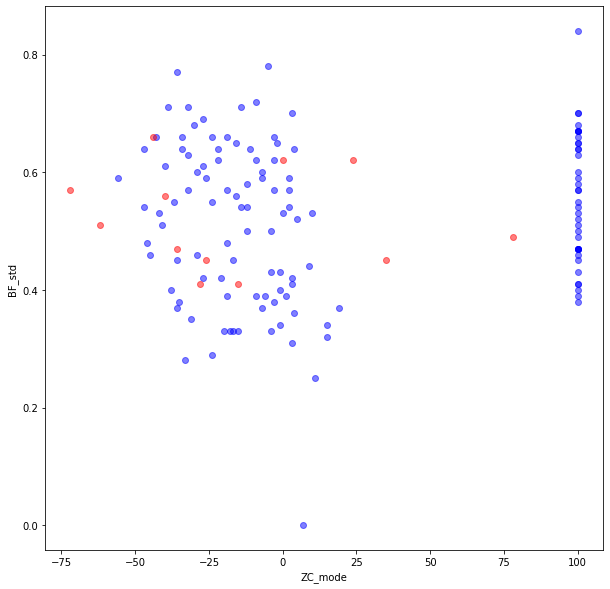

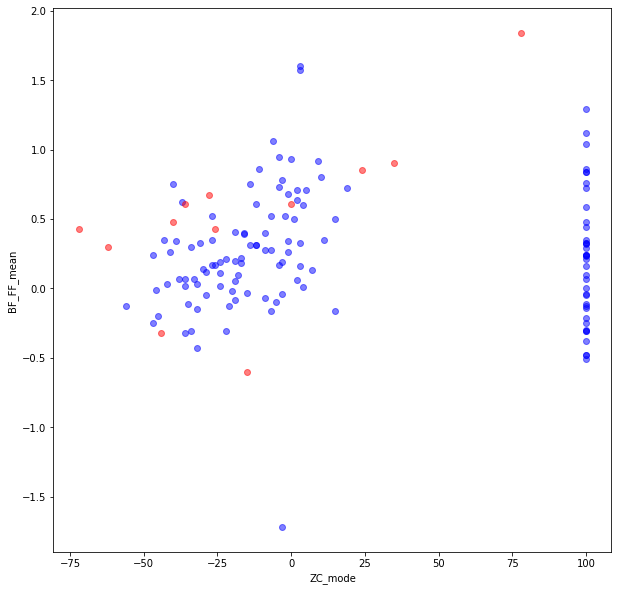

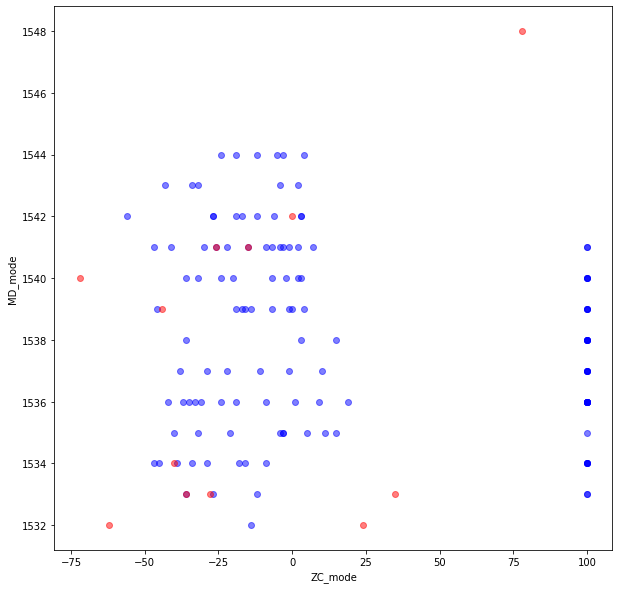

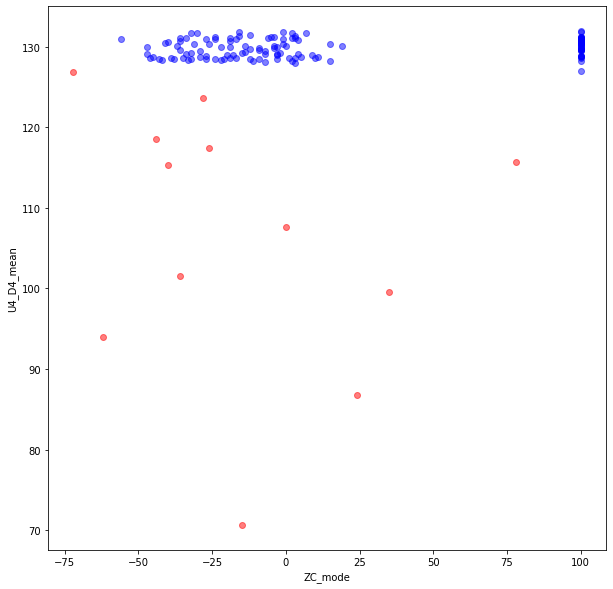

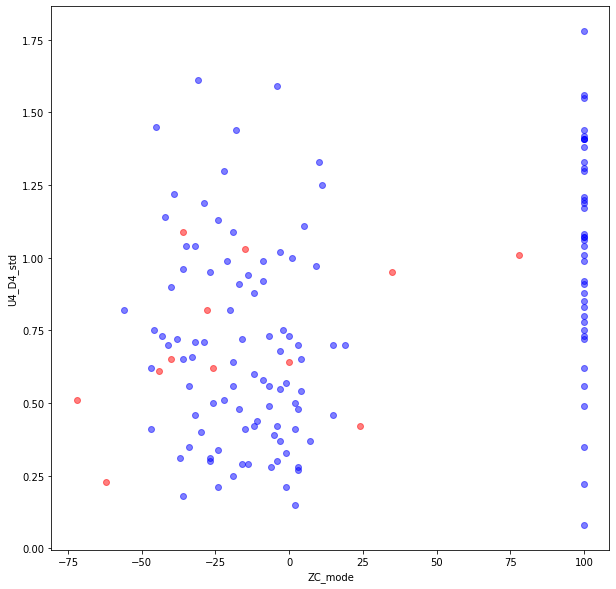

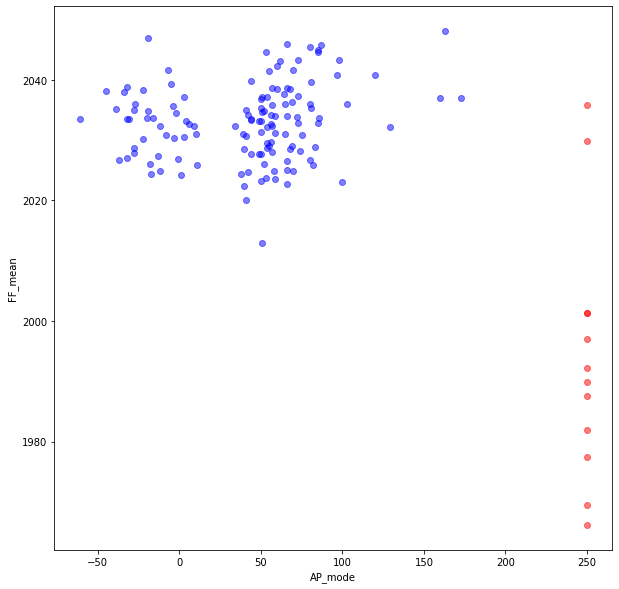

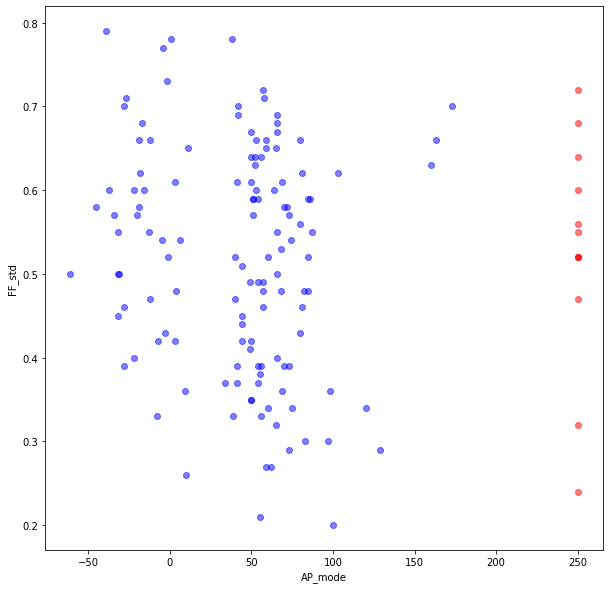

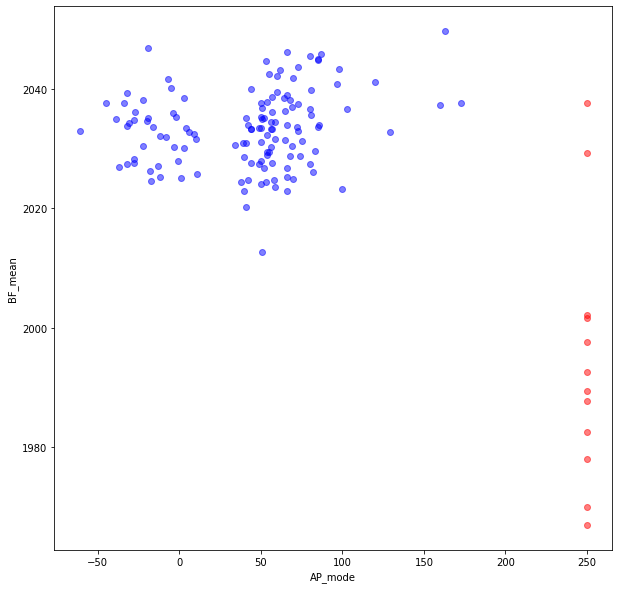

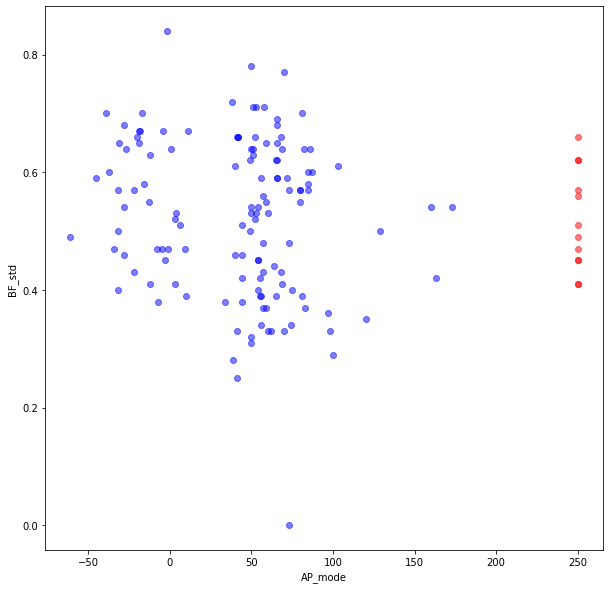

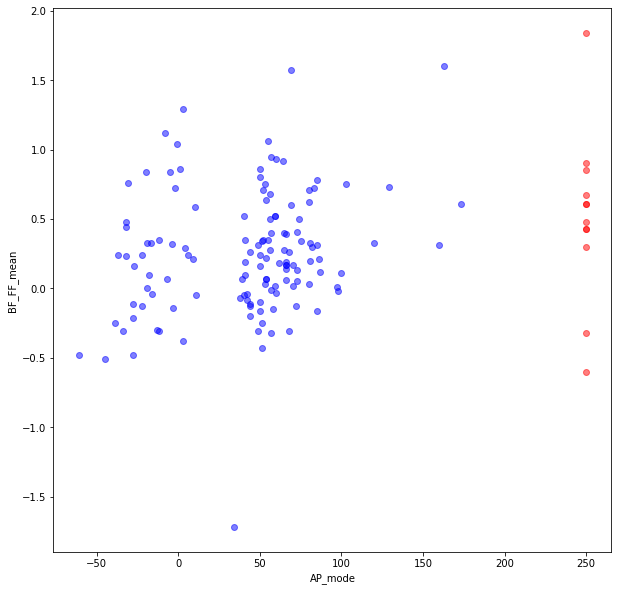

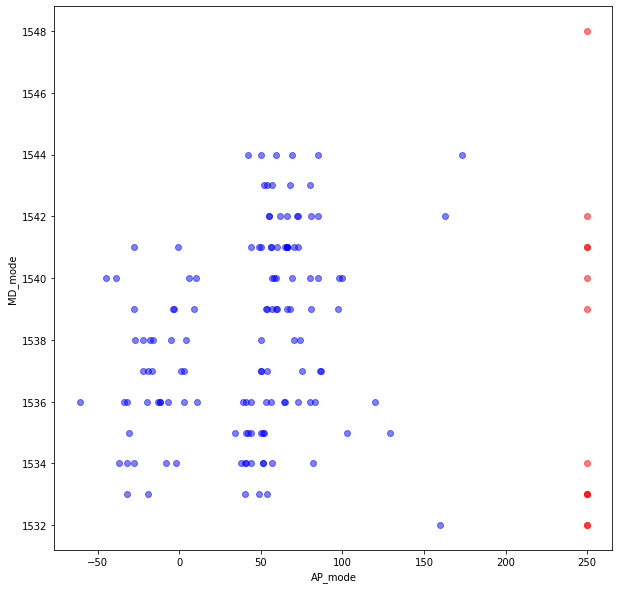

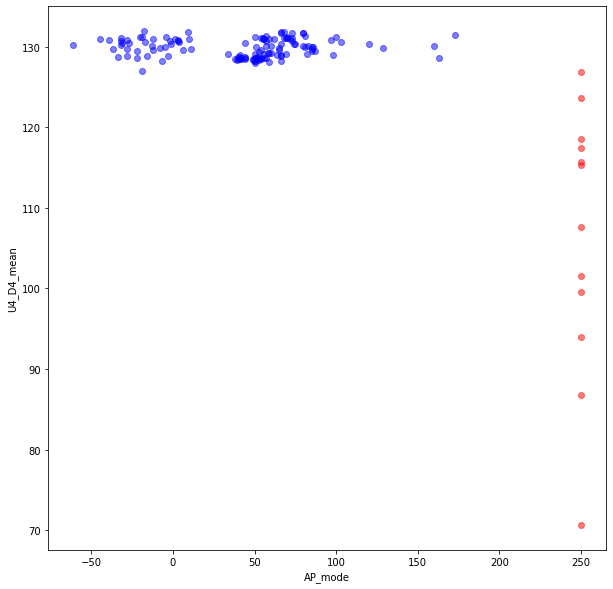

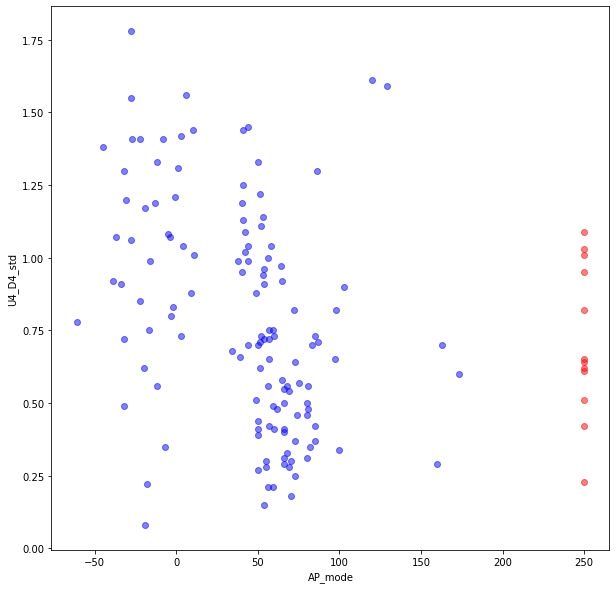

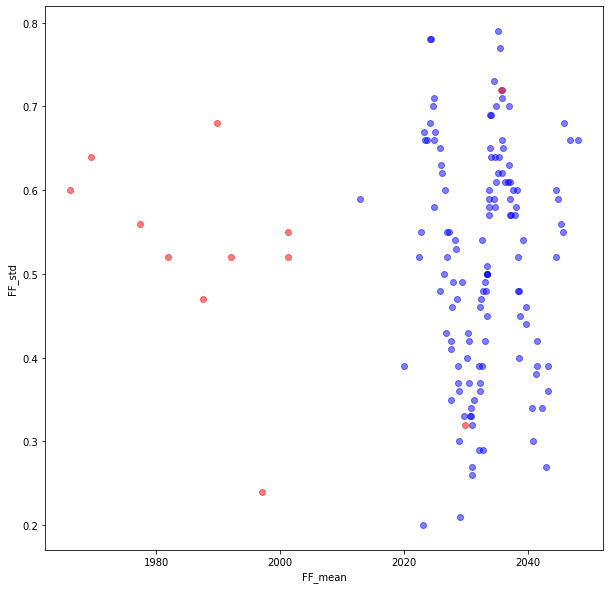

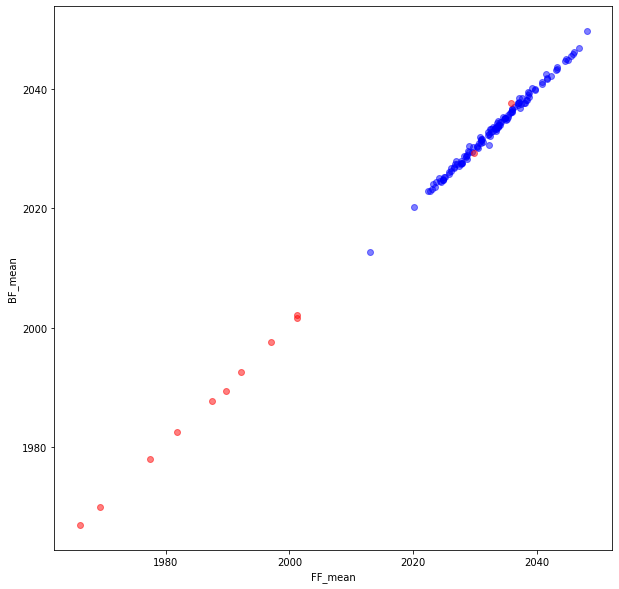

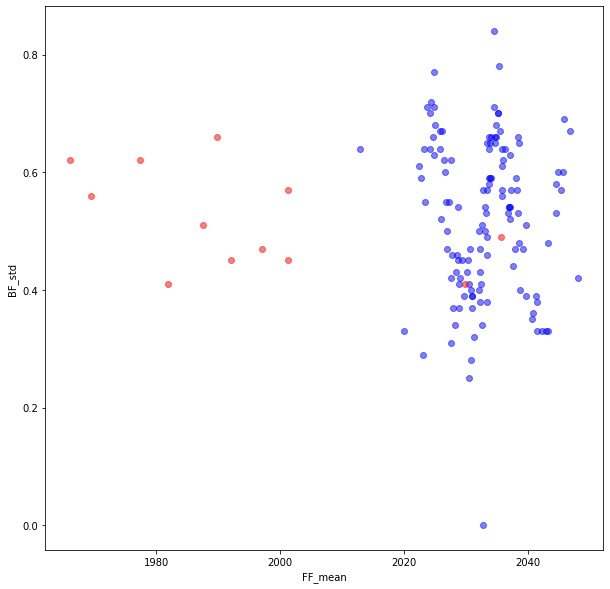

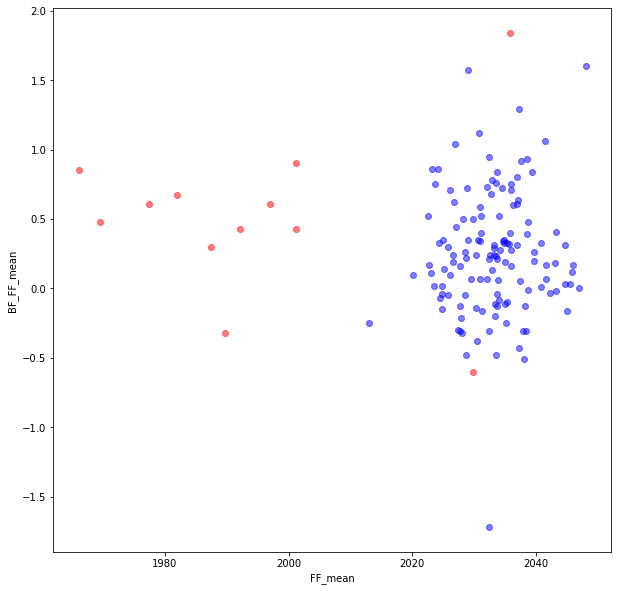

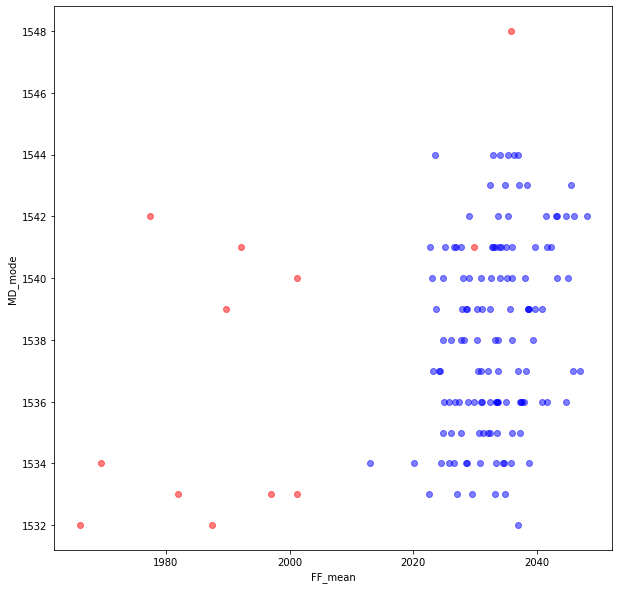

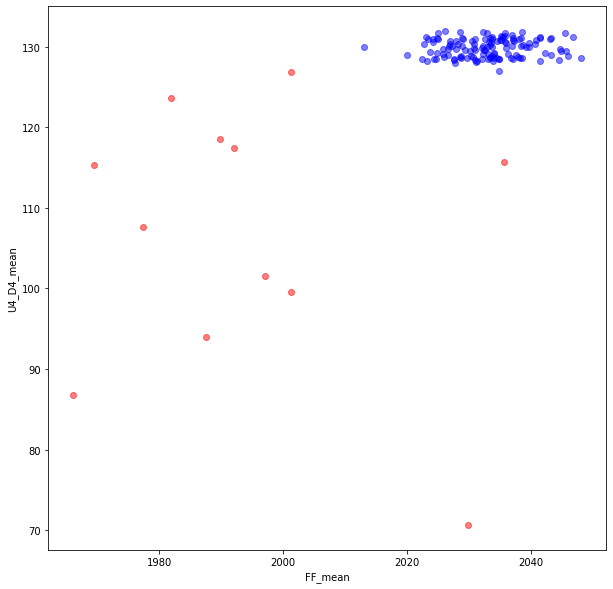

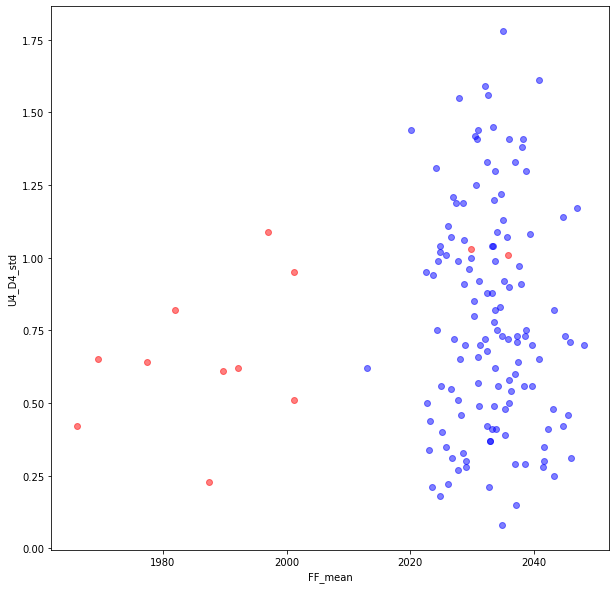

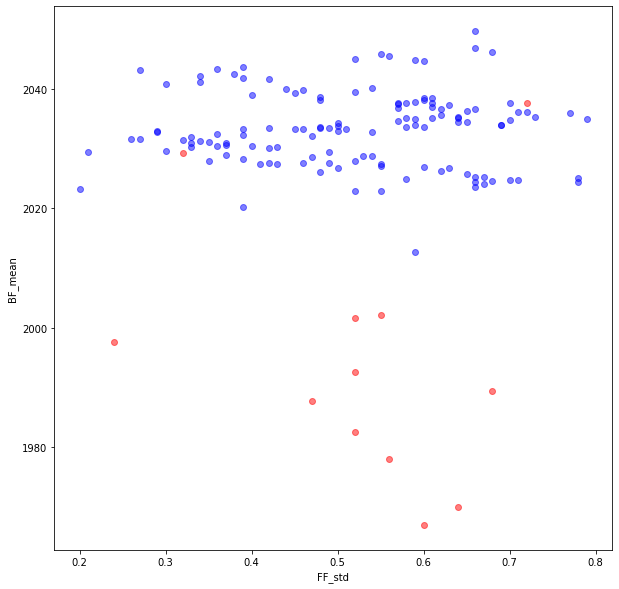

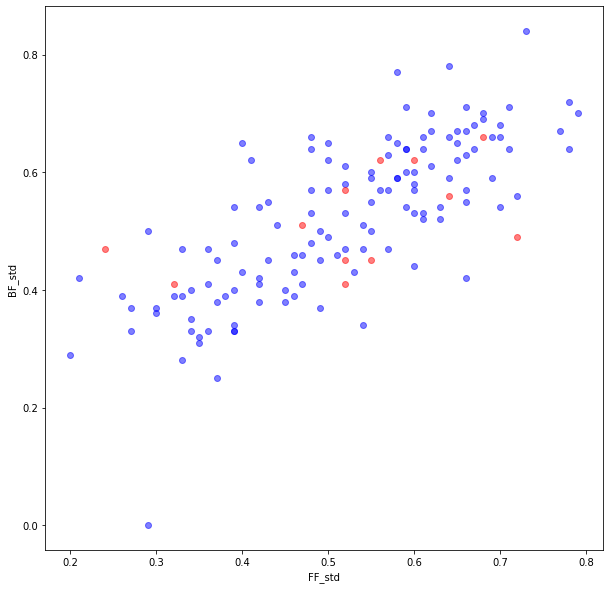

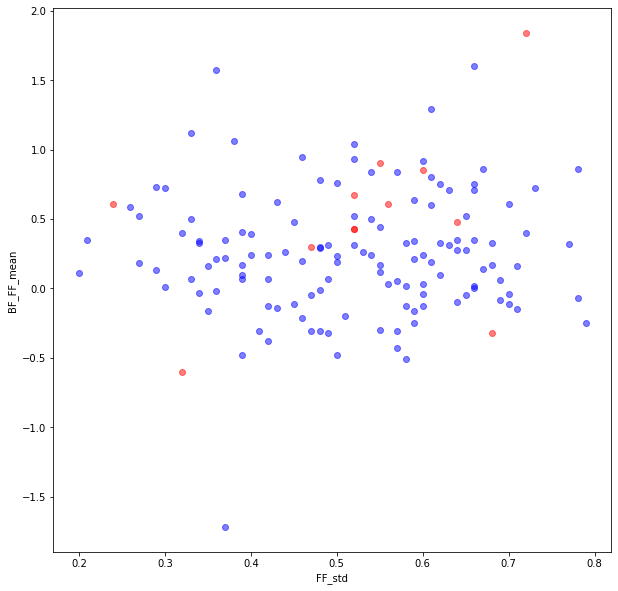

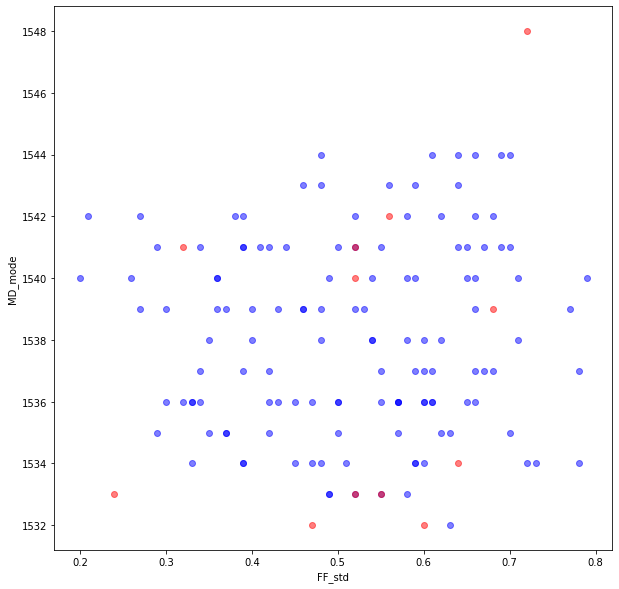

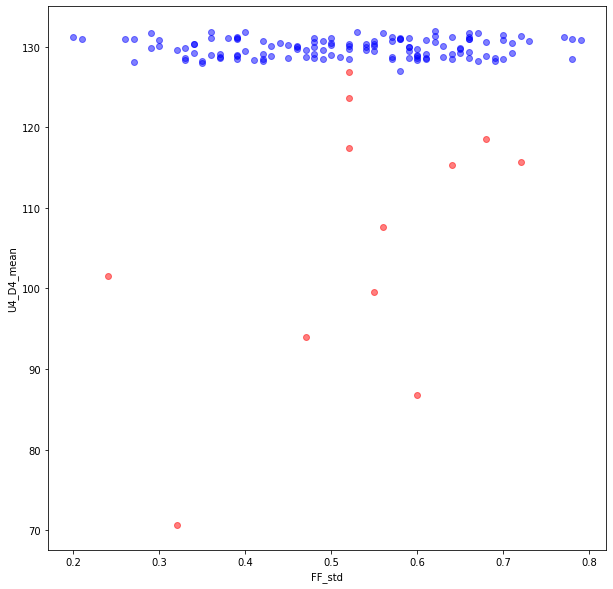

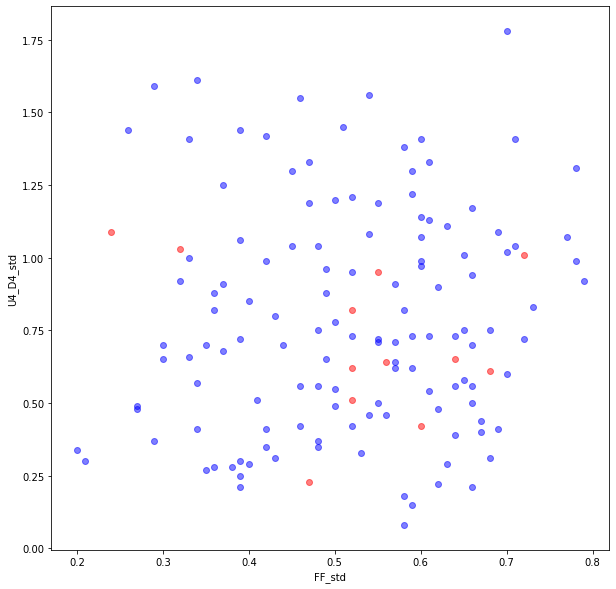

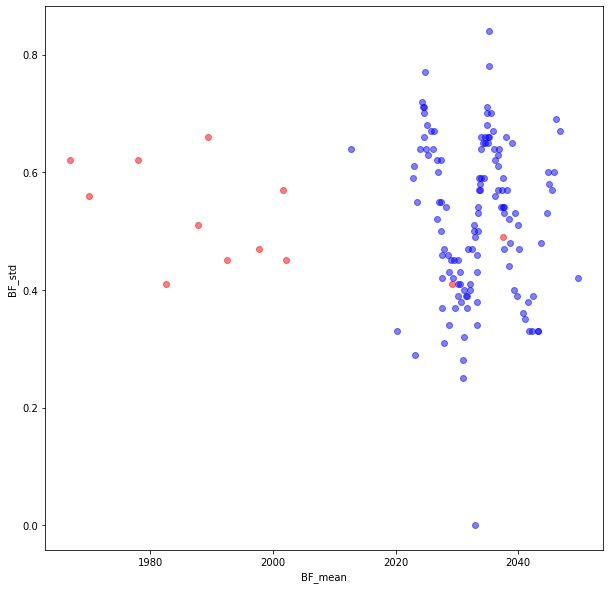

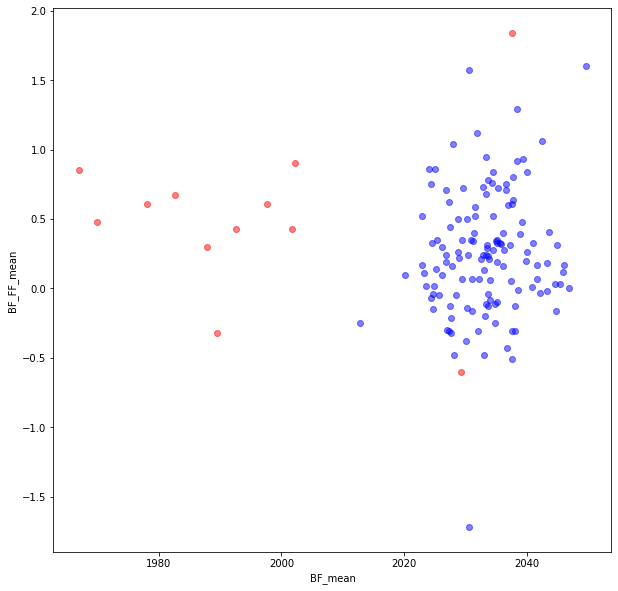

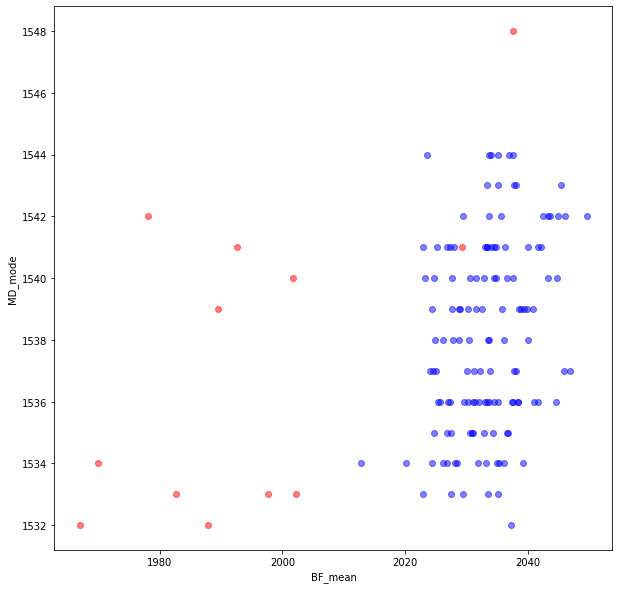

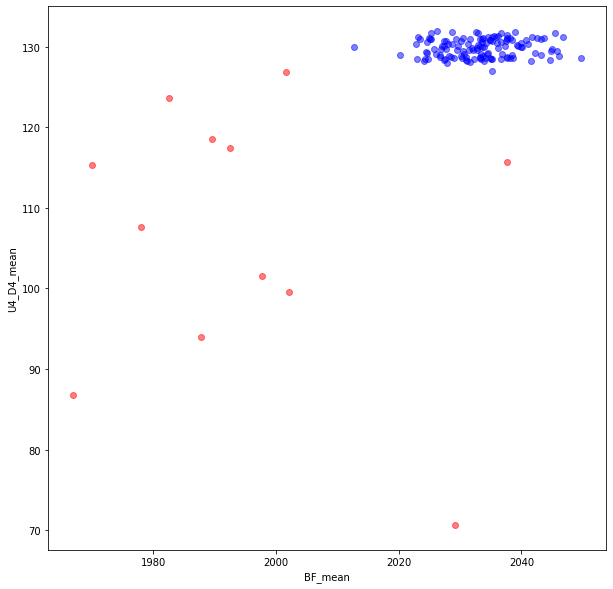

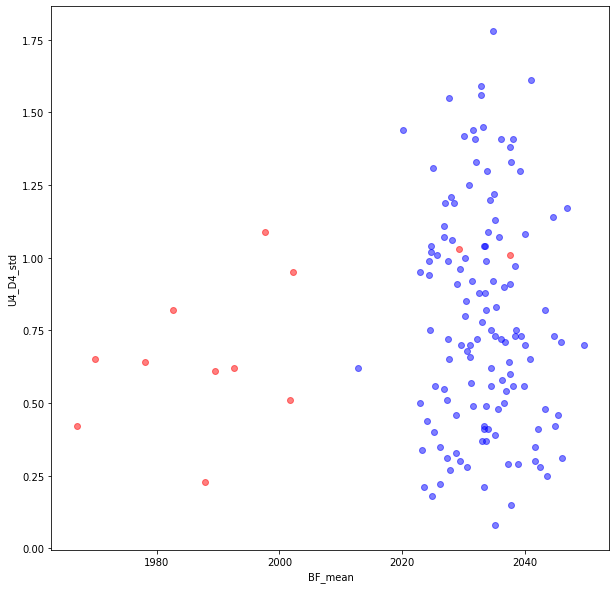

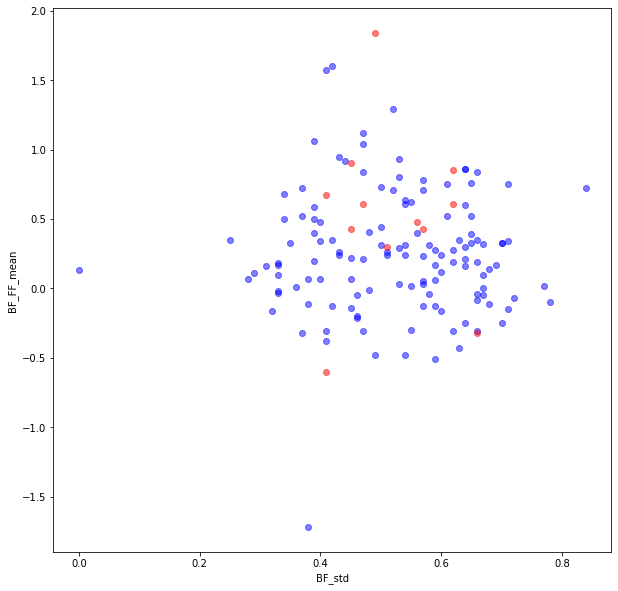

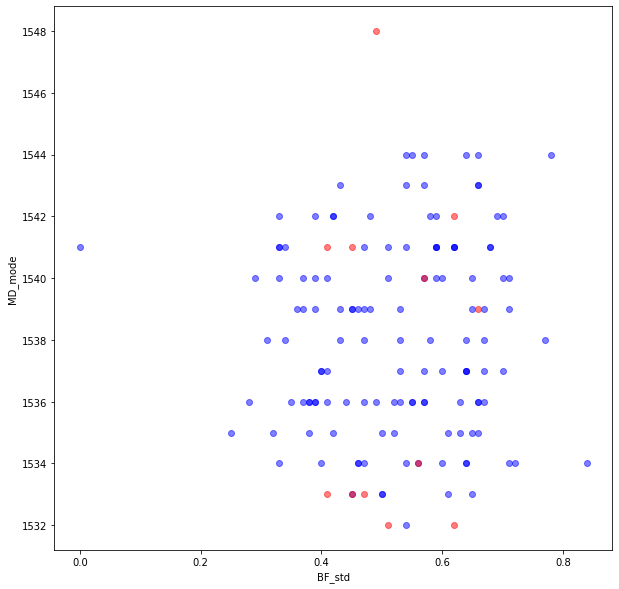

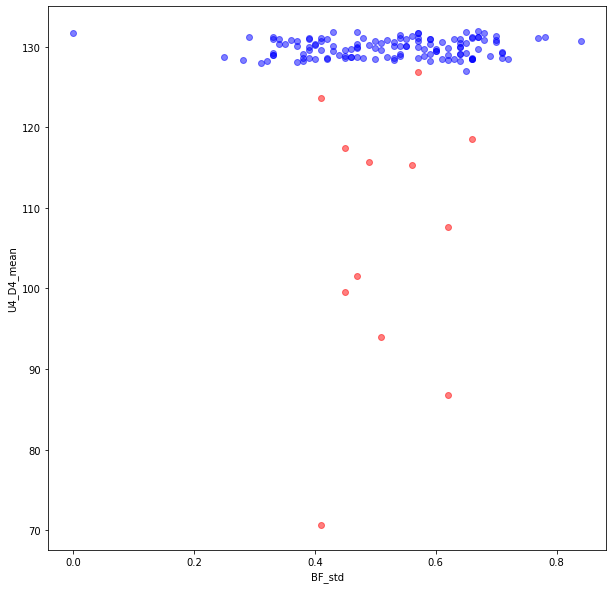

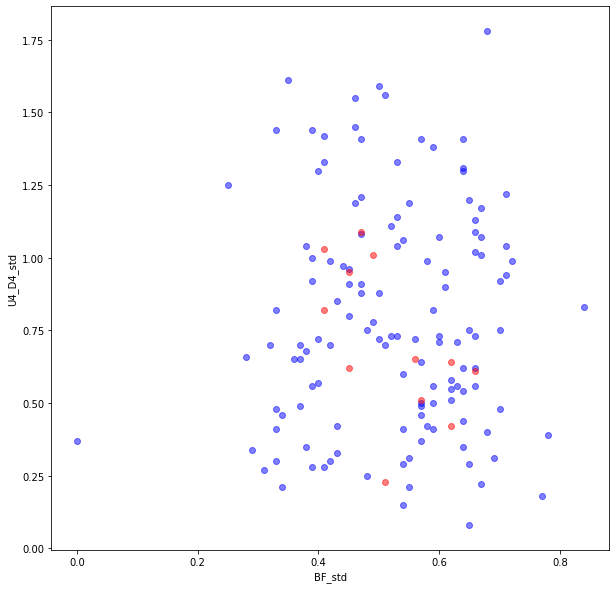

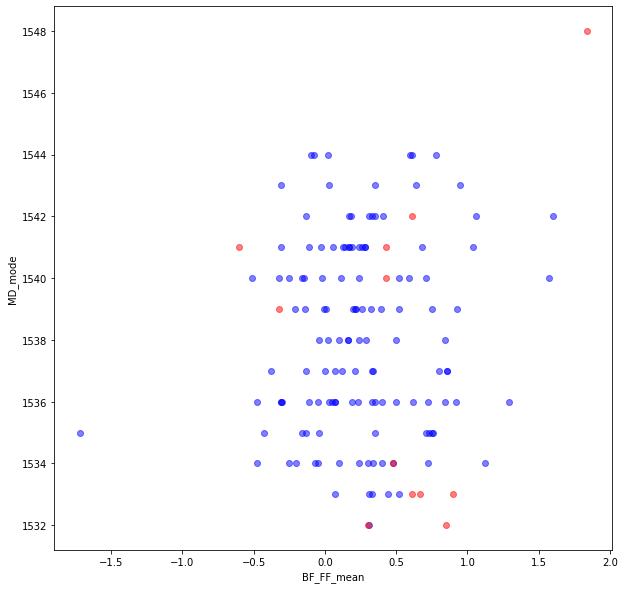

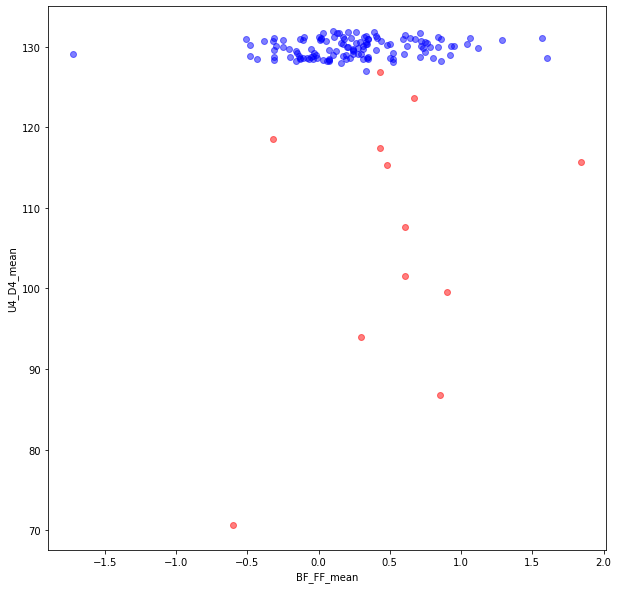

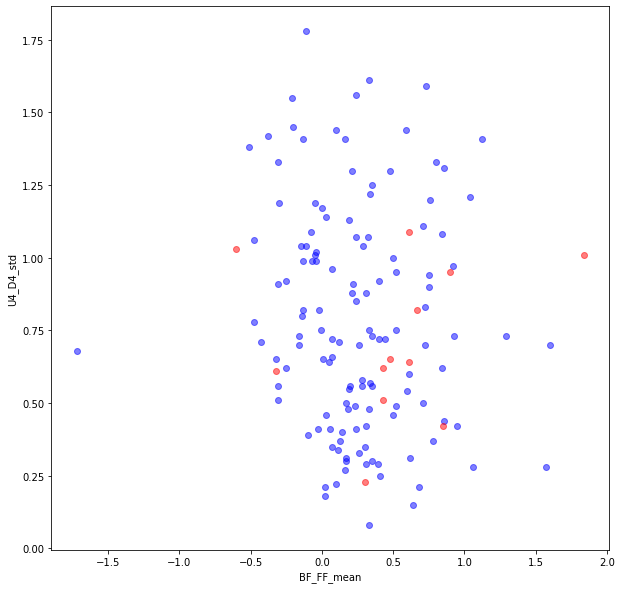

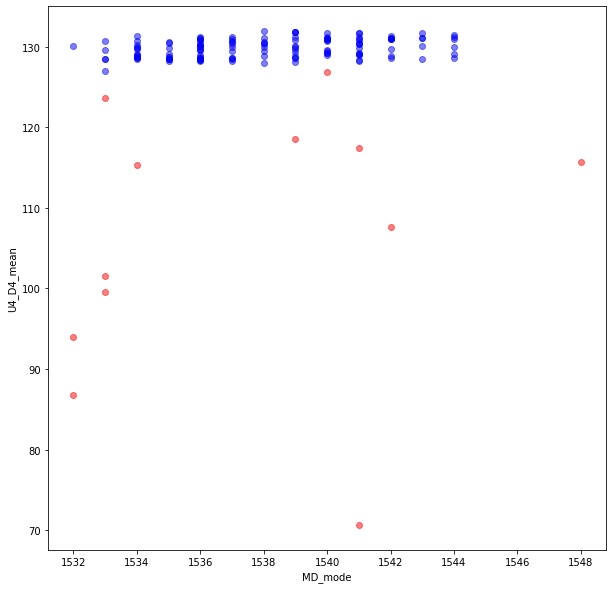

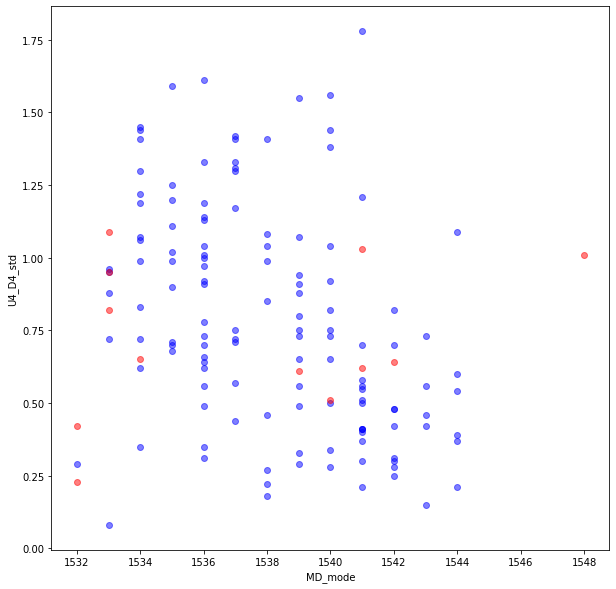

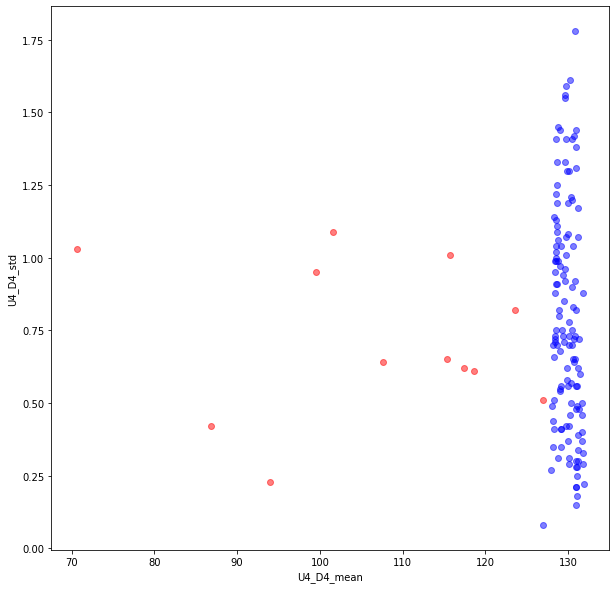

In [ ]:
# 산점도

for i in df.columns:
  if i == 'sample_name': continue
  for j in df.columns:
    if df.columns.to_list().index(i) > df.columns.to_list().index(j): continue
    elif j == 'error' or i == j: continue

    plt.figure(figsize=(10, 10))
    plt.xlabel('{}'.format(i))
    plt.ylabel('{}'.format(j)) 

    plt.scatter(x = df.loc[df['error']==0, '{}'.format(i)], y = df.loc[df['error']==0, '{}'.format(j)], alpha = 0.5, color='b')
    plt.scatter(x = df.loc[df['error']==1, '{}'.format(i)], y = df.loc[df['error']==1, '{}'.format(j)], alpha = 0.5, color='r')
    plt.show()
    print()

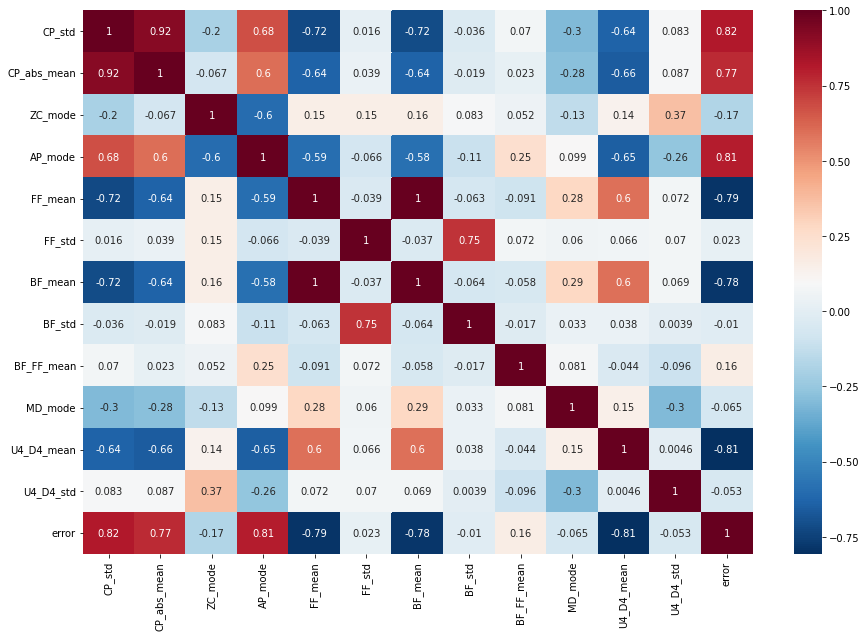

In [ ]:
# 상관관계

df_corr = df.drop(columns='sample_name').corr(method='pearson')
plt.figure(figsize = (15,10))
sns.heatmap(df_corr, xticklabels = df_corr.columns, yticklabels = df_corr.columns, cmap = 'RdBu_r', annot = True)
plt.show()

# 3. 불량품 구별 중요 변수 선정

> ## 3.1 데이터 증식

In [ ]:
# 오버 샘플링

smote_sample = SMOTE(sampling_strategy=0.6, random_state=0)
x_sm, y_sm = smote_sample.fit_resample(df.drop(['error', 'sample_name', 'AP_mode'], axis=1), df['error'])
Counter(y_sm)

Counter({0: 130, 1: 78})

In [ ]:
# 데이터 재할당

df_cla = pd.DataFrame()
df_cla = x_sm
df_cla['error'] = y_sm

In [ ]:
df_cla

,CP_std,CP_abs_mean,ZC_mode,FF_mean,FF_std,BF_mean,BF_std,BF_FF_mean,MD_mode,U4_D4_mean,U4_D4_std,error
0,1.840000,1.470000,15.000000,2031.290000,0.350000,2031.130000,0.320000,-0.160000,1535.000000,128.250000,0.700000,0
1,2.060000,1.630000,-32.000000,2045.470000,0.560000,2045.500000,0.570000,0.030000,1543.000000,131.690000,0.460000,0
2,1.790000,1.380000,-32.000000,2037.190000,0.570000,2036.760000,0.630000,-0.430000,1535.000000,128.430000,0.710000,0
3,3.260000,2.230000,19.000000,2028.910000,0.300000,2029.630000,0.370000,0.720000,1536.000000,130.100000,0.700000,0
4,1.940000,1.330000,-12.000000,2033.170000,0.490000,2033.480000,0.500000,0.310000,1533.000000,128.460000,0.880000,0
...,...,...,...,...,...,...,...,...,...,...,...,...
203,6.612150,5.141170,21.076274,1991.774019,0.553978,1992.558651,0.517630,0.784632,1536.580387,102.800413,0.826676,1
204,5.393068,3.902923,-41.788714,1978.561139,0.657887,1978.687868,0.604718,0.122257,1536.235893,116.802274,0.632113,1
205,5.824741,4.072263,-39.340238,1974.020707,0.574024,1974.522150,0.545155,0.501442,1533.835060,113.075367,0.722574,1
206,4.622564,3.355998,-10.354627,1979.067834,0.545208,1979.700023,0.542340,0.632188,1538.671727,113.565835,0.706565,1


> ## 3.2 분류 모델

In [ ]:
# 데이터 분할

X_train, X_test, y_train, y_test = train_test_split(df_cla.drop(['error'], axis=1), df_cla['error'], test_size=0.2,  random_state=11)

In [ ]:
# 오차계산 함수 정의

def get_clf_eval(y_test, pred=None, pred_proba=None):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test , pred)
  precision = precision_score(y_test , pred)
  recall = recall_score(y_test , pred)
  f1 = f1_score(y_test,pred)
  print('오차 행렬')
  print(confusion)
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}'.format(accuracy, precision, recall, f1))

In [ ]:
# 하이퍼 파라미터 정의

fold = 4

dt_params = { 
    'max_depth' : [2, 4, 6],
    'min_samples_leaf' : [2, 4, 6],
    'min_samples_split' : [2, 4, 6]
    }

rf_params = { 
    'n_estimators' : [10, 100, 200],
    'max_depth' : [2, 4, 6],
    'min_samples_leaf' : [2, 4, 6],
    'min_samples_split' : [2, 4, 6]
    }

gbm_params = {
    'n_estimators':[100, 200, 300],
    'max_depth':[1, 3, 5],
    'learning_rate' : [0.01, 0.05, 0.1],
    'subsample': [0.5, 0.7, 0.9]
    }

lg_params={
    'n_estimators': [10, 30, 50],
    'num_leaves': [5, 10, 15],
    'min_child_samples': [2, 3, 4],
    'max_depth': [-1, 3, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'reg_alpha': [0, 0.01],
    'subsample': [0.6, 0.8, 1]
    }

xgb_params = { 
    'learning_rate': [0.01, 0.1, 0.2],
    'num_boost_rounds': [100, 300, 500],
    'min_child_weight': [1, 2, 3],
    'gamma': [0, 0.2, 0.4],
    'max_depth':[1, 3, 5],
    'subsample': [0.5, 0.7, 0.9],
    'colsample_bytree': [0.5, 0.7, 0.9]
    }

et_params = { 
    'n_estimators':[100, 200, 300],
    'max_depth':[1, 3, 5],
    'min_samples_split':[2, 6, 10],
    'min_samples_leaf':[1, 3, 5]
    }       

cat_params = {
    'iterations': [50, 100],
    'depth': [2, 3, 4],
    'loss_function': ['Logloss'],
    'leaf_estimation_iterations': [2, 3, 4],
    'logging_level':['Silent'],
    'random_seed': [42]
    }    

>> ### 3.3.1 Decison Tree

In [ ]:
# Grid search

dt_clf = DecisionTreeClassifier(random_state=0)
grid_cv = GridSearchCV(dt_clf , param_grid=dt_params, verbose=1, cv=fold ,scoring='f1')
grid_cv.fit(X_train , y_train)

print()
print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 f1: {0:.4f}'.format(grid_cv.best_score_))

Fitting 4 folds for each of 27 candidates, totalling 108 fits

최적 하이퍼 파라미터:
 {'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 2}
최고 예측 f1: 0.9848


In [ ]:
# 훈련 데이터와 테스트 데이터 성능 확인

dt_pred = grid_cv.best_estimator_.predict(X_train)
get_clf_eval(y_train, dt_pred)
print()

dt_pred = grid_cv.best_estimator_.predict(X_test)
get_clf_eval(y_test, dt_pred)

오차 행렬
[[101   0]
 [  0  65]]
정확도: 1.0000, 정밀도: 1.0000, 재현율: 1.0000, F1: 1.0000

오차 행렬
[[29  0]
 [ 0 13]]
정확도: 1.0000, 정밀도: 1.0000, 재현율: 1.0000, F1: 1.0000


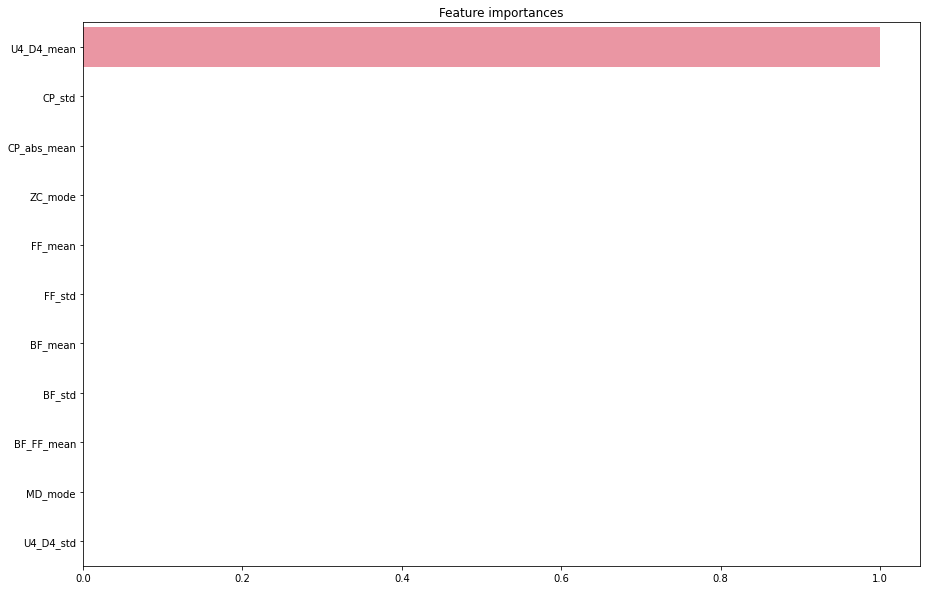

In [ ]:
# 변수 중요도 확인

dt_importances_values = grid_cv.best_estimator_.feature_importances_
ftr_importances = pd.Series(dt_importances_values,index=X_train.columns  )
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(15, 10))
plt.title('Feature importances')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()

>> ### 3.3.2 Random Forest

In [ ]:
# Grid search

rf_clf = RandomForestClassifier(random_state=0)
grid_cv = GridSearchCV(rf_clf , param_grid=rf_params, verbose=1, cv=fold ,scoring='f1')
grid_cv.fit(X_train , y_train)

print()
print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 f1: {0:.4f}'.format(grid_cv.best_score_))

Fitting 4 folds for each of 81 candidates, totalling 324 fits

최적 하이퍼 파라미터:
 {'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
최고 예측 f1: 1.0000


In [ ]:
# 훈련 데이터와 테스트 데이터 성능 확인

rf_pred = grid_cv.best_estimator_.predict(X_train)
get_clf_eval(y_train, rf_pred)
print()

rf_pred = grid_cv.best_estimator_.predict(X_test)
get_clf_eval(y_test, rf_pred)

오차 행렬
[[101   0]
 [  0  65]]
정확도: 1.0000, 정밀도: 1.0000, 재현율: 1.0000, F1: 1.0000

오차 행렬
[[29  0]
 [ 0 13]]
정확도: 1.0000, 정밀도: 1.0000, 재현율: 1.0000, F1: 1.0000


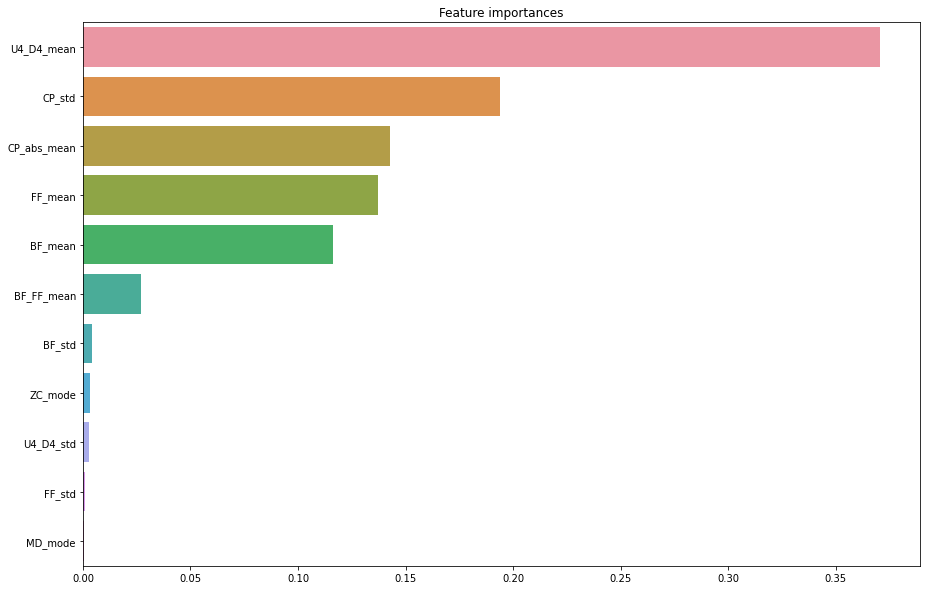

In [ ]:
# 변수 중요도 확인

rf_importances_values = grid_cv.best_estimator_.feature_importances_
ftr_importances = pd.Series(rf_importances_values,index=X_train.columns  )
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(15, 10))
plt.title('Feature importances')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()

>> ### 3.3.3 GBM

In [ ]:
# Grid search

gbm_clf = GradientBoostingClassifier(random_state=0)
grid_cv = GridSearchCV(gbm_clf , param_grid=gbm_params, verbose=1, cv=fold ,scoring='f1')
grid_cv.fit(X_train , y_train)

print()
print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 f1: {0:.4f}'.format(grid_cv.best_score_))

Fitting 4 folds for each of 81 candidates, totalling 324 fits

최적 하이퍼 파라미터:
 {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.5}
최고 예측 f1: 1.0000


In [ ]:
# 훈련 데이터와 테스트 데이터 성능 확인

gbm_pred = grid_cv.best_estimator_.predict(X_train)
get_clf_eval(y_train, gbm_pred)
print()

gbm_pred = grid_cv.best_estimator_.predict(X_test)
get_clf_eval(y_test, gbm_pred)

오차 행렬
[[101   0]
 [  0  65]]
정확도: 1.0000, 정밀도: 1.0000, 재현율: 1.0000, F1: 1.0000

오차 행렬
[[29  0]
 [ 0 13]]
정확도: 1.0000, 정밀도: 1.0000, 재현율: 1.0000, F1: 1.0000


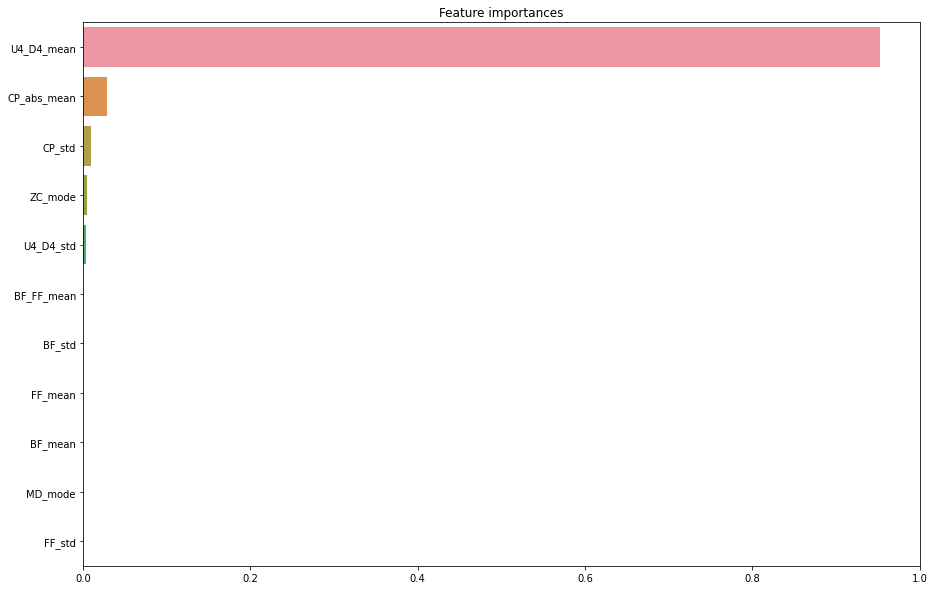

In [ ]:
# 변수 중요도 확인

gbm_importances_values = grid_cv.best_estimator_.feature_importances_
ftr_importances = pd.Series(gbm_importances_values,index=X_train.columns  )
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(15, 10))
plt.title('Feature importances')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()

>> ### 3.3.4 LightGBM

In [ ]:
# Grid search

lg_clf = lightgbm.LGBMClassifier(random_state=0)
grid_cv = GridSearchCV(lg_clf , param_grid=lg_params, verbose=1, cv=fold ,scoring='f1')
grid_cv.fit(X_train , y_train)

print()
print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 f1: {0:.4f}'.format(grid_cv.best_score_))

Fitting 4 folds for each of 1458 candidates, totalling 5832 fits

최적 하이퍼 파라미터:
 {'learning_rate': 0.05, 'max_depth': -1, 'min_child_samples': 2, 'n_estimators': 30, 'num_leaves': 5, 'reg_alpha': 0, 'subsample': 0.6}
최고 예측 f1: 0.9924


In [ ]:
# 훈련 데이터와 테스트 데이터 성능 확인

lg_pred = grid_cv.best_estimator_.predict(X_train)
get_clf_eval(y_train, lg_pred)
print()

lg_pred = grid_cv.best_estimator_.predict(X_test)
get_clf_eval(y_test, lg_pred)

오차 행렬
[[101   0]
 [  0  65]]
정확도: 1.0000, 정밀도: 1.0000, 재현율: 1.0000, F1: 1.0000

오차 행렬
[[29  0]
 [ 0 13]]
정확도: 1.0000, 정밀도: 1.0000, 재현율: 1.0000, F1: 1.0000


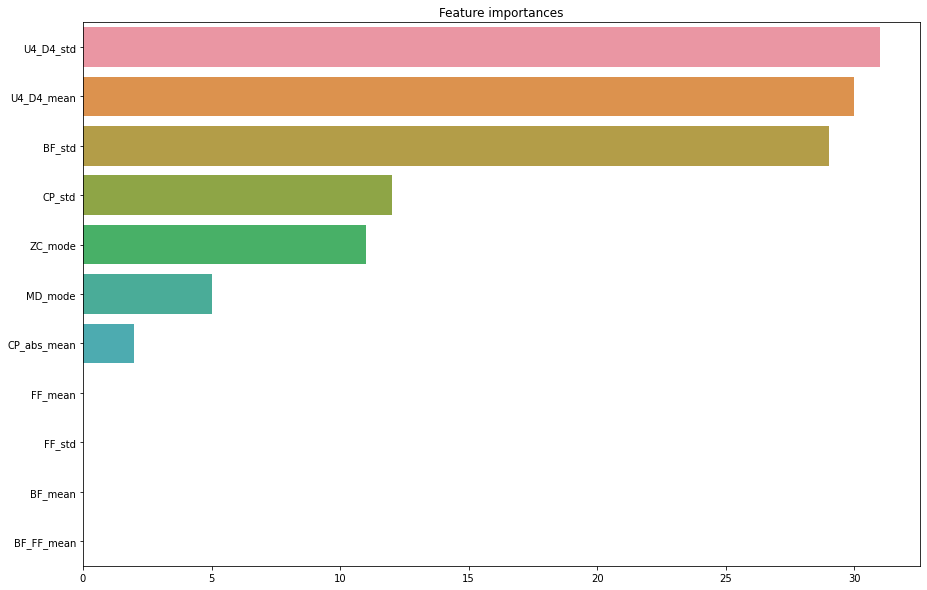

In [ ]:
# 변수 중요도 확인

lg_importances_values = grid_cv.best_estimator_.feature_importances_
ftr_importances = pd.Series(lg_importances_values,index=X_train.columns  )
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(15, 10))
plt.title('Feature importances')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()

>> ### 3.3.5 XGBoost

In [ ]:
# Grid search

xgb_clf = XGBClassifier(objective='binary:logistic', random_state=0)
grid_cv = GridSearchCV(xgb_clf , param_grid=xgb_params, verbose=1, cv=fold ,scoring='f1')
grid_cv.fit(X_train , y_train)

print()
print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 f1: {0:.4f}'.format(grid_cv.best_score_))

Fitting 4 folds for each of 2187 candidates, totalling 8748 fits

최적 하이퍼 파라미터:
 {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 1, 'min_child_weight': 1, 'num_boost_rounds': 100, 'subsample': 0.5}
최고 예측 f1: 1.0000


In [ ]:
# 훈련 데이터와 테스트 데이터 성능 확인

xgb_pred = grid_cv.best_estimator_.predict(X_train)
get_clf_eval(y_train, xgb_pred)
print()

xgb_pred = grid_cv.best_estimator_.predict(X_test)
get_clf_eval(y_test, xgb_pred)

오차 행렬
[[101   0]
 [  0  65]]
정확도: 1.0000, 정밀도: 1.0000, 재현율: 1.0000, F1: 1.0000

오차 행렬
[[29  0]
 [ 0 13]]
정확도: 1.0000, 정밀도: 1.0000, 재현율: 1.0000, F1: 1.0000


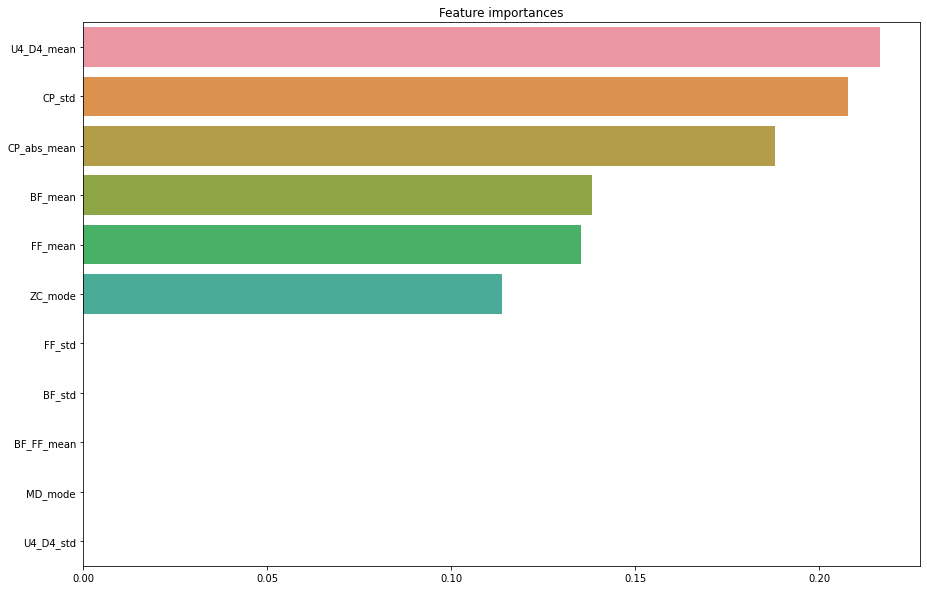

In [ ]:
# 변수 중요도 확인

xgb_importances_values = grid_cv.best_estimator_.feature_importances_
ftr_importances = pd.Series(xgb_importances_values,index=X_train.columns  )
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(15, 10))
plt.title('Feature importances')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()

>> ### 3.3.6 Extra trees

In [ ]:
# Grid search

et_clf = ExtraTreesClassifier(random_state=0)
grid_cv = GridSearchCV(et_clf , param_grid=et_params, verbose=1, cv=fold ,scoring='f1')
grid_cv.fit(X_train , y_train)

print()
print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 f1: {0:.4f}'.format(grid_cv.best_score_))

Fitting 4 folds for each of 81 candidates, totalling 324 fits

최적 하이퍼 파라미터:
 {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
최고 예측 f1: 1.0000


In [ ]:
# 훈련 데이터와 테스트 데이터 성능 확인

et_pred = grid_cv.best_estimator_.predict(X_train)
get_clf_eval(y_train, et_pred)
print()

et_pred = grid_cv.best_estimator_.predict(X_test)
get_clf_eval(y_test, et_pred)

오차 행렬
[[101   0]
 [  0  65]]
정확도: 1.0000, 정밀도: 1.0000, 재현율: 1.0000, F1: 1.0000

오차 행렬
[[29  0]
 [ 0 13]]
정확도: 1.0000, 정밀도: 1.0000, 재현율: 1.0000, F1: 1.0000


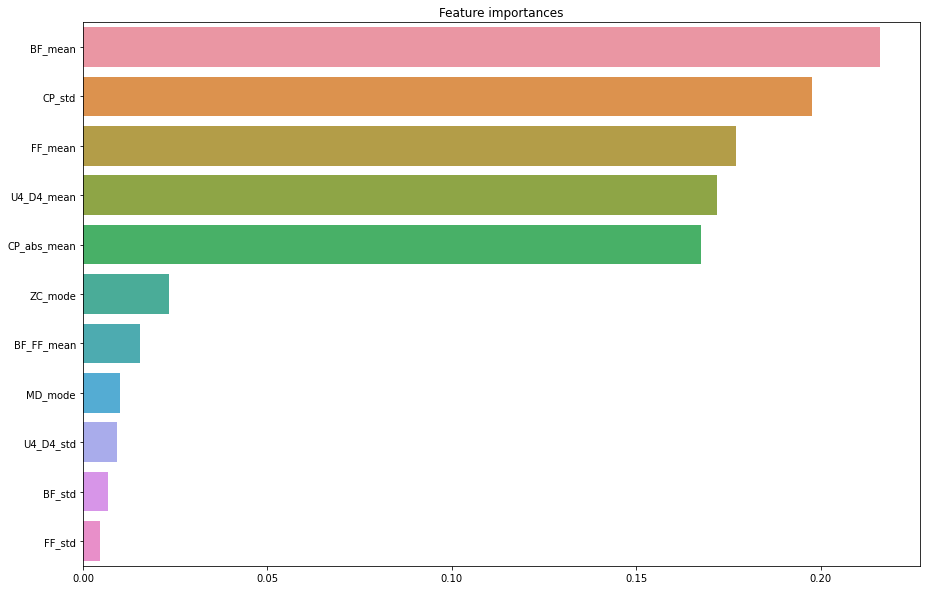

In [ ]:
# 변수 중요도 확인

et_importances_values = grid_cv.best_estimator_.feature_importances_
ftr_importances = pd.Series(et_importances_values,index=X_train.columns  )
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(15, 10))
plt.title('Feature importances')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()

>> ### 3.3.7 CatBoost

In [ ]:
# Grid search

cat_clf = CatBoostClassifier()
grid_cv = GridSearchCV(cat_clf , param_grid=cat_params, verbose=1, cv=fold ,scoring='f1')
grid_cv.fit(X_train , y_train)

print()
print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 f1: {0:.4f}'.format(grid_cv.best_score_))

Fitting 4 folds for each of 18 candidates, totalling 72 fits

최적 하이퍼 파라미터:
 {'depth': 2, 'iterations': 50, 'leaf_estimation_iterations': 2, 'logging_level': 'Silent', 'loss_function': 'Logloss', 'random_seed': 42}
최고 예측 f1: 1.0000


In [ ]:
# 훈련 데이터와 테스트 데이터 성능 확인

cat_pred = grid_cv.best_estimator_.predict(X_train)
get_clf_eval(y_train, cat_pred)
print()

cat_pred = grid_cv.best_estimator_.predict(X_test)
get_clf_eval(y_test, cat_pred)

오차 행렬
[[101   0]
 [  0  65]]
정확도: 1.0000, 정밀도: 1.0000, 재현율: 1.0000, F1: 1.0000

오차 행렬
[[29  0]
 [ 0 13]]
정확도: 1.0000, 정밀도: 1.0000, 재현율: 1.0000, F1: 1.0000


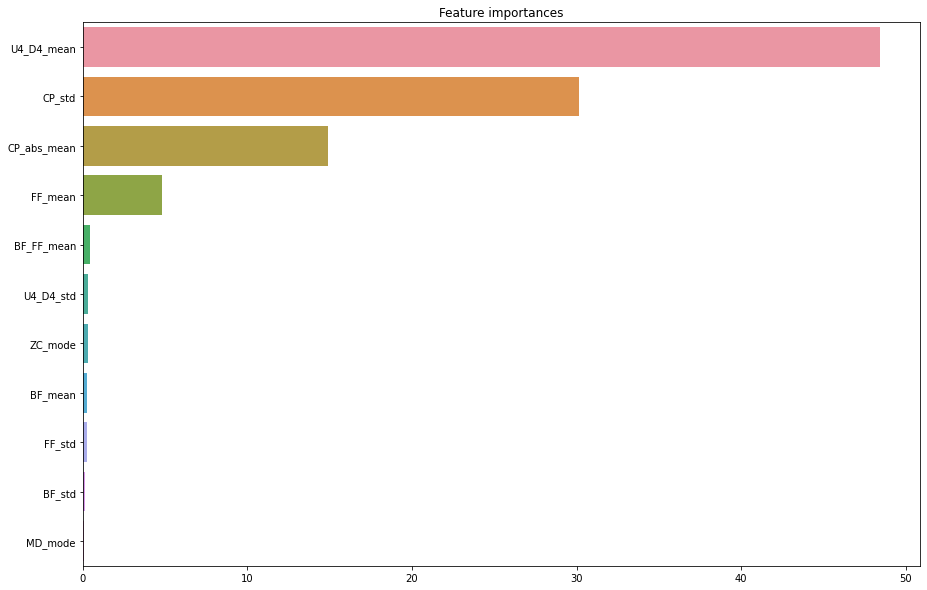

In [ ]:
# 변수 중요도 확인

cat_importances_values = grid_cv.best_estimator_.feature_importances_
ftr_importances = pd.Series(cat_importances_values,index=X_train.columns  )
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(15, 10))
plt.title('Feature importances')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()

>> ### 3.3.8 변수 중요도 종합

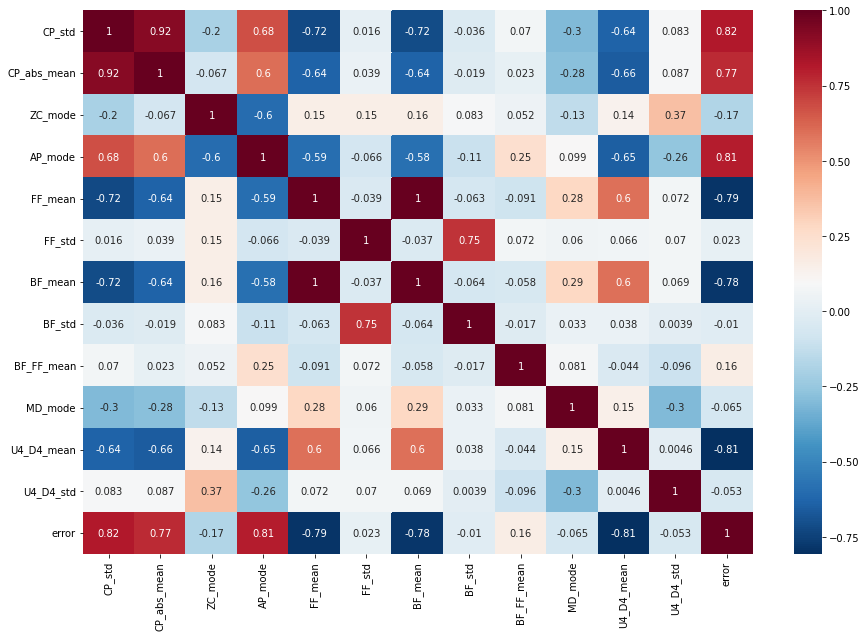

In [ ]:
# 상관관계

df_corr = df.corr(method='pearson')
plt.figure(figsize = (15,10))
sns.heatmap(df_corr, xticklabels = df_corr.columns, yticklabels = df_corr.columns, cmap = 'RdBu_r', annot = True)
plt.show()

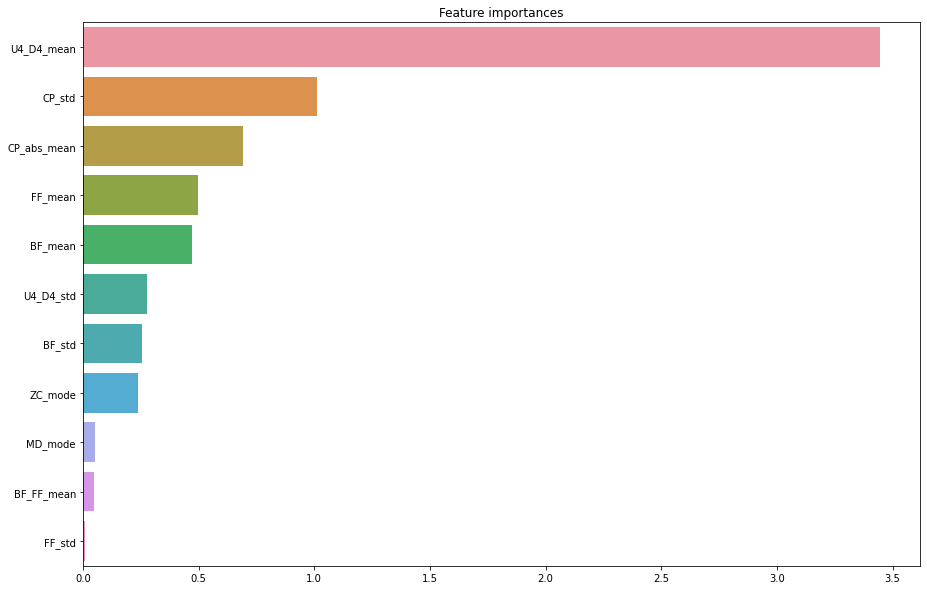

In [ ]:
# 변수 중요도 확인

importances_values = cat_importances_values/100 + et_importances_values + xgb_importances_values + lg_importances_values/120 + gbm_importances_values + rf_importances_values + dt_importances_values
ftr_importances = pd.Series(importances_values,index=X_train.columns  )
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(15, 10))
plt.title('Feature importances')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()


# 4. 군집 분석

> ## 4.1 데이터 2차 가공

In [ ]:
# 최대 최소 이상치 함수 정의

def max_iqr(dt, col):
    quartile_1, quartile_3 = np.percentile(dt[col], [25, 75])
    iqr = quartile_3 - quartile_1
    upper_whis = quartile_3 + (iqr * 1.5)
    outliers = dt[(dt[col] > upper_whis)]
    return outliers[[col]], upper_whis

def min_iqr(dt, col):
    quartile_1, quartile_3 = np.percentile(dt[col], [25, 75])
    iqr = quartile_3 - quartile_1
    lower_whis = quartile_1 - (iqr * 1.5)
    outliers = dt[(dt[col] < lower_whis)]
    return outliers[[col]], lower_whis 

In [ ]:
# 불량품 drop

is_error = df[df['error'] == 1].index
df_clu = df.drop(is_error)

In [ ]:
df_clu

,sample_name,CP_std,CP_abs_mean,ZC_mode,AP_mode,FF_mean,FF_std,BF_mean,BF_std,BF_FF_mean,MD_mode,U4_D4_mean,U4_D4_std,error
0,A3,1.84,1.47,15.0,50.0,2031.29,0.35,2031.13,0.32,-0.16,1535.0,128.25,0.70,0
1,AAA44,2.06,1.63,-32.0,80.0,2045.47,0.56,2045.50,0.57,0.03,1543.0,131.69,0.46,0
2,A9,1.79,1.38,-32.0,51.0,2037.19,0.57,2036.76,0.63,-0.43,1535.0,128.43,0.71,0
3,A23,3.26,2.23,19.0,83.0,2028.91,0.30,2029.63,0.37,0.72,1536.0,130.10,0.70,0
4,A2,1.94,1.33,-12.0,49.0,2033.17,0.49,2033.48,0.50,0.31,1533.0,128.46,0.88,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,AAA41,2.08,1.79,-20.0,98.0,2043.29,0.36,2043.27,0.33,-0.02,1540.0,128.96,0.82,0
138,AAA76,1.85,1.64,100.0,-16.0,2033.74,0.60,2033.70,0.58,-0.04,1538.0,128.83,0.99,0
139,AAA67,1.69,1.53,100.0,-5.0,2039.28,0.54,2040.12,0.47,0.84,1538.0,130.03,1.08,0
140,AAA52,2.25,1.77,-22.0,86.0,2033.70,0.59,2033.91,0.64,0.21,1537.0,129.93,1.30,0


In [ ]:
# columns drop

df_clu.drop(['sample_name', 'ZC_mode', 'FF_std', 'BF_std', 'BF_FF_mean', 'MD_mode', 'U4_D4_std', 'error'], axis=1, inplace=True)

In [ ]:
df_clu

,CP_std,CP_abs_mean,AP_mode,FF_mean,BF_mean,U4_D4_mean
0,1.84,1.47,50.0,2031.29,2031.13,128.25
1,2.06,1.63,80.0,2045.47,2045.50,131.69
2,1.79,1.38,51.0,2037.19,2036.76,128.43
3,3.26,2.23,83.0,2028.91,2029.63,130.10
4,1.94,1.33,49.0,2033.17,2033.48,128.46
...,...,...,...,...,...,...
137,2.08,1.79,98.0,2043.29,2043.27,128.96
138,1.85,1.64,-16.0,2033.74,2033.70,128.83
139,1.69,1.53,-5.0,2039.28,2040.12,130.03
140,2.25,1.77,86.0,2033.70,2033.91,129.93


In [ ]:
# 이상치 대치

for i in df_clu.columns:
  max_outliers, upper_whis = max_iqr(df_clu, i)

  df_clu.loc[max_outliers.index, i] = np.NAN
  df_clu[i].fillna(upper_whis, inplace=True)

  min_outliers, lower_whis = min_iqr(df_clu, i)

  df_clu.loc[min_outliers.index, i] = np.NAN
  df_clu[i].fillna(lower_whis, inplace=True)  

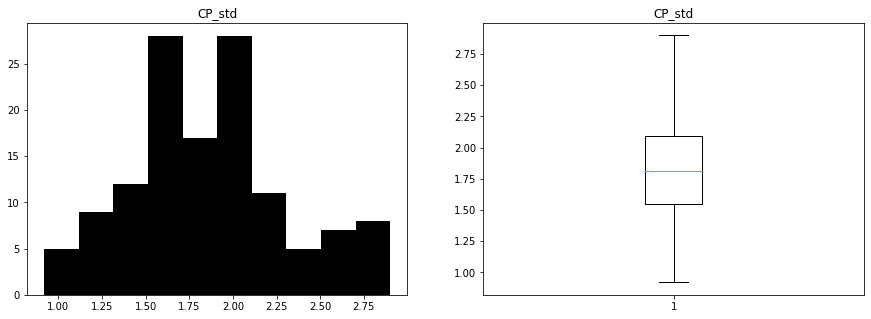

평균: 1.8534615384615383
중앙값: 1.815
최빈값: [1.37, 1.53, 1.56, 1.57, 1.66, 1.91, 1.94, 2.06, 2.09, 2.12, 2.8999999999999995]
최대값: 2.8999999999999995
최소값: 0.92
표준편차: 0.46351155716499853


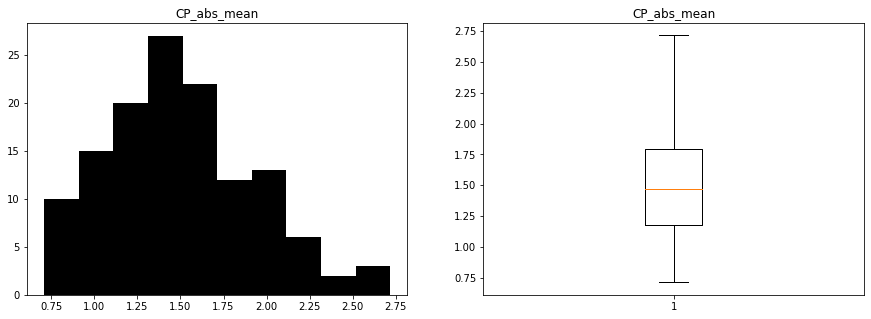

평균: 1.5090673076923076
중앙값: 1.4649999999999999
최빈값: [1.42, 1.63]
최대값: 2.7162500000000005
최소값: 0.71
표준편차: 0.43816569817659934


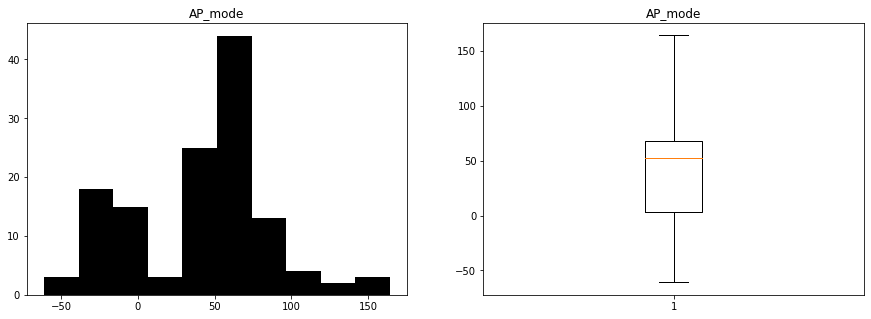

평균: 41.69423076923077
중앙값: 52.0
최빈값: [50.0, 66.0]
최대값: 164.25
최소값: -61.0
표준편차: 44.37463031164508


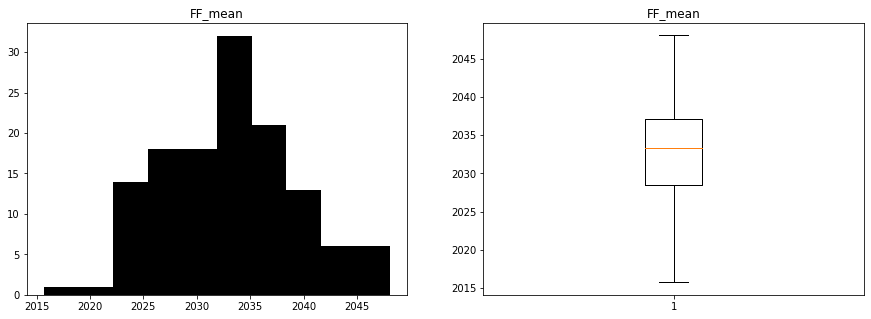

평균: 2033.0715192307691
중앙값: 2033.3200000000002
최빈값: [2033.74, 2034.82]
최대값: 2048.09
최소값: 2015.7175
표준편차: 6.262185551190124


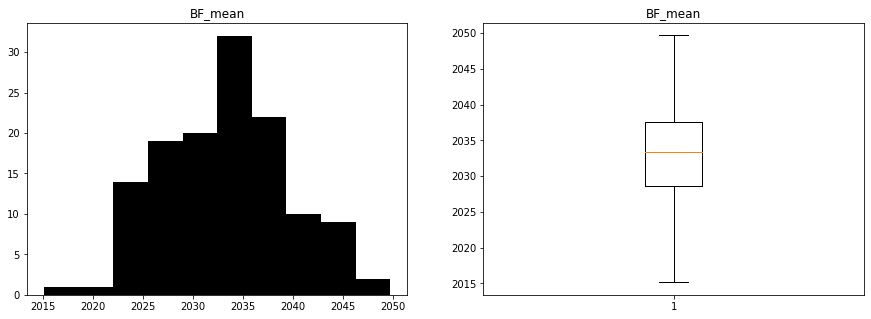

평균: 2033.3199134615384
중앙값: 2033.435
최빈값: [2036.64, 2037.6]
최대값: 2049.69
최소값: 2015.13875
표준편차: 6.308602070354789


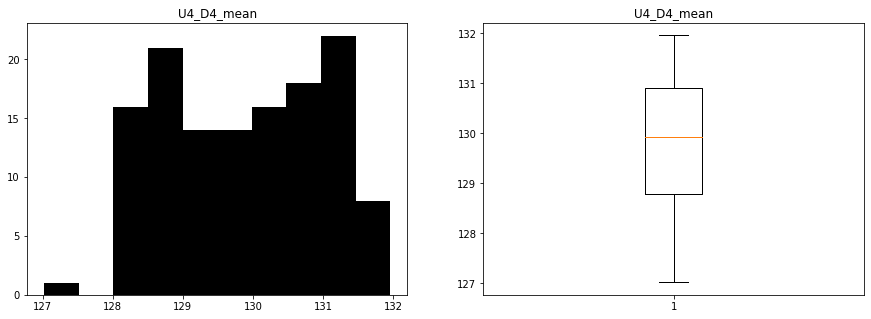

평균: 129.86661538461541
중앙값: 129.925
최빈값: [128.46, 128.55, 129.66]
최대값: 131.96
최소값: 127.02
표준편차: 1.1260203323691647


In [ ]:
# 히스토그램 & 박스 플롯

for i in df_clu.columns:
  if i == 'sample_name' or i == 'error': continue   

  plt.figure(figsize=(15, 5))
  plt.subplot(1, 2, 1)
  plt.title('{}'.format(i))
  plt.hist('{}'.format(i), color='k', data = df_clu)

  plt.subplot(1, 2, 2)
  plt.title('{}'.format(i))
  plt.boxplot(df_clu['{}'.format(i)], whis=1.5)  
  plt.show()
  
  print("평균: {}".format((df_clu['{}'.format(i)].mean())))
  print("중앙값: {}".format((df_clu['{}'.format(i)].median())))
  print("최빈값: {}".format((list(df_clu['{}'.format(i)].mode()))))
  print("최대값: {}".format((df_clu['{}'.format(i)].max())))
  print("최소값: {}".format((df_clu['{}'.format(i)].min())))
  print("표준편차: {}".format((df_clu['{}'.format(i)].std())))

In [ ]:
# 컬럼 경향 동기화

df_clu['CP_std'] = 1 / df_clu['CP_std']
df_clu['CP_abs_mean'] = 1 / df_clu['CP_abs_mean']
df_clu['AP_mode'] = 1 / df_clu['AP_mode']

In [ ]:
df_clu

,CP_std,CP_abs_mean,AP_mode,FF_mean,BF_mean,U4_D4_mean
0,0.543478,0.680272,0.020000,2031.29,2031.13,128.25
1,0.485437,0.613497,0.012500,2045.47,2045.50,131.69
2,0.558659,0.724638,0.019608,2037.19,2036.76,128.43
3,0.344828,0.448430,0.012048,2028.91,2029.63,130.10
4,0.515464,0.751880,0.020408,2033.17,2033.48,128.46
...,...,...,...,...,...,...
137,0.480769,0.558659,0.010204,2043.29,2043.27,128.96
138,0.540541,0.609756,-0.062500,2033.74,2033.70,128.83
139,0.591716,0.653595,-0.200000,2039.28,2040.12,130.03
140,0.444444,0.564972,0.011628,2033.70,2033.91,129.93


In [ ]:
# 스케일링

scaler = MinMaxScaler()
df_minmax = scaler.fit_transform(df_clu.iloc[:,:])

df_minmax = pd.DataFrame(df_minmax)
# df_minmax.columns = [ 'CP_std', 'CP_abs_mean', 'FF_mean', 'BF_mean', 'U4_D4_mean'] 
df_minmax.columns = [ 'CP_std', 'CP_abs_mean', 'AP_mode', 'FF_mean', 'BF_mean', 'U4_D4_mean'] 

In [ ]:
# 칼럼 재조합

df_fi = pd.DataFrame()
df_fi['freq_sta'] = (df_minmax['CP_std']+df_minmax['CP_abs_mean'])/2
df_fi['freq_app'] = (df_minmax['FF_mean']+df_minmax['BF_mean'])/2
# df_fi['amp'] = df_minmax['U4_D4_mean']   
df_fi['amp'] = (df_minmax['U4_D4_mean']+df_minmax['AP_mode'])/2   

> ## 4.2 군집 모델

In [ ]:
# 변수 및 시각화 함수 정의

n_clusters = [2, 3, 4, 5]
model = []
params = []
sil_value = []

def sil_view(model, df):
  sil_avg = silhouette_score(df, model.labels_)
  sil_values = silhouette_samples(df, model.labels_)

  plt.figure(figsize=(10, 10))
  y_lower = 10

  for i in range(max(model.labels_)+1):
      ith_cluster_sil_values = sil_values[model.labels_==i]
      ith_cluster_sil_values.sort()
      
      size_cluster_i = ith_cluster_sil_values.shape[0]
      y_upper = y_lower + size_cluster_i
      
      color = cm.nipy_spectral(float(i) / (max(model.labels_)+1))
      plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                          facecolor=color, edgecolor=color, alpha=0.7)
      plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
      y_lower = y_upper + 10
      
  plt.title('Average: {}'.format(sil_avg))
  plt.axvline(x=sil_avg, color="red", linestyle="--")
  plt.show()    

  return sil_avg

>> ### 4.2.1 K-means

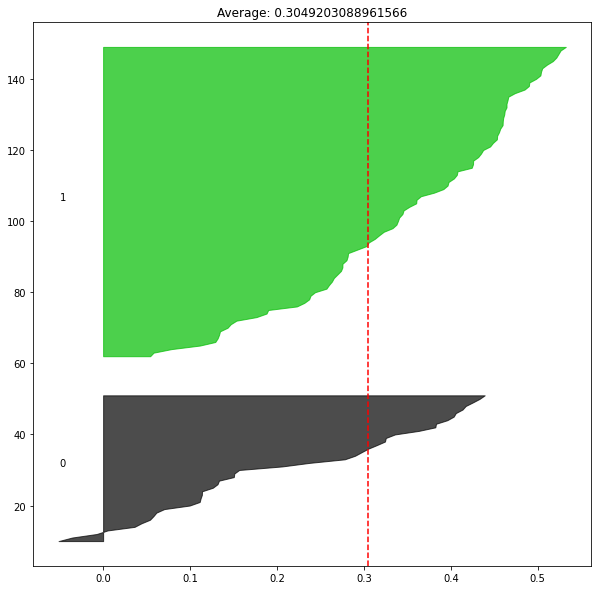

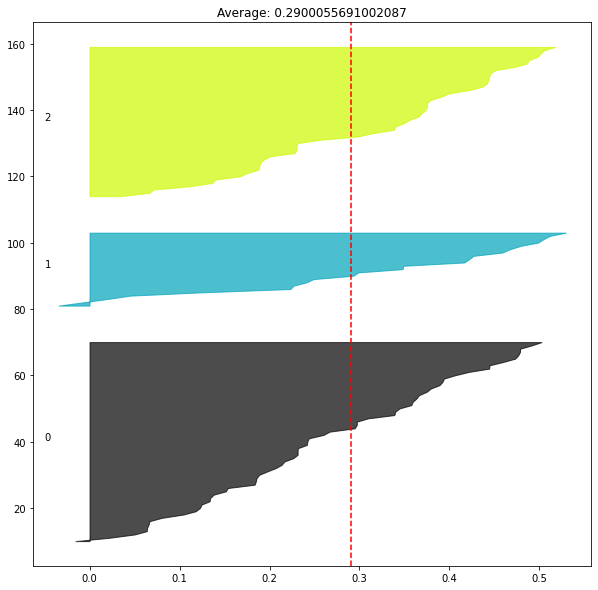

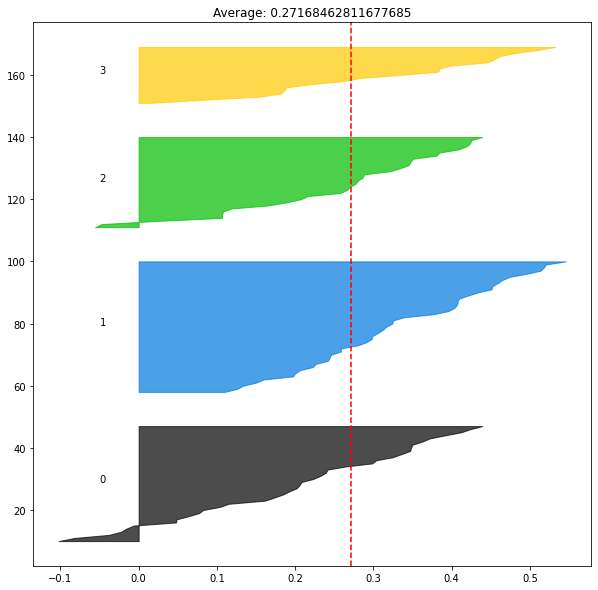

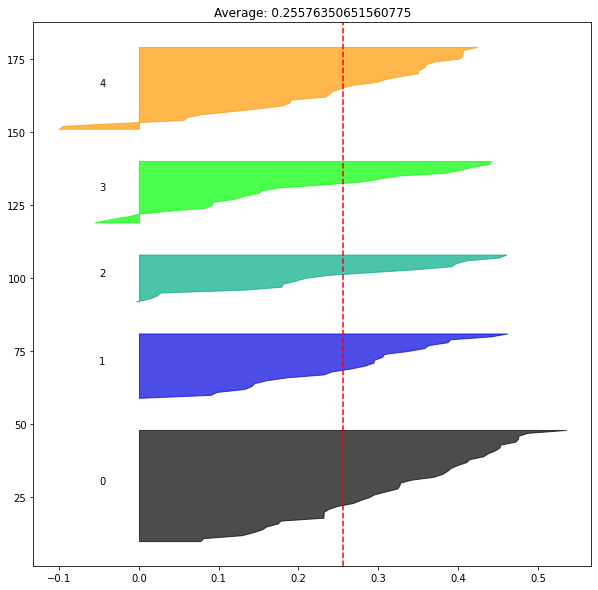

In [ ]:
# 클러스터 수 최적화

for i in n_clusters:
  kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=500, random_state=0)
  kmeans.fit(df_fi)

  model.append('kmeans')
  params.append(i)
  sil_value.append(sil_view(kmeans, df_fi))

>> ### 4.2.2 Agglomerative

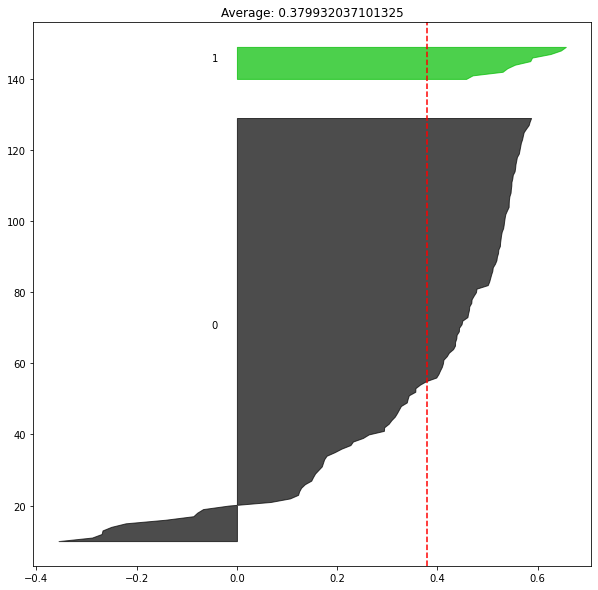

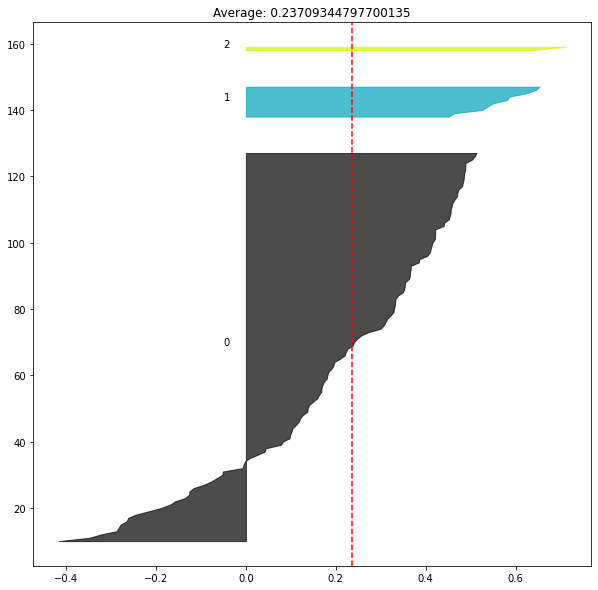

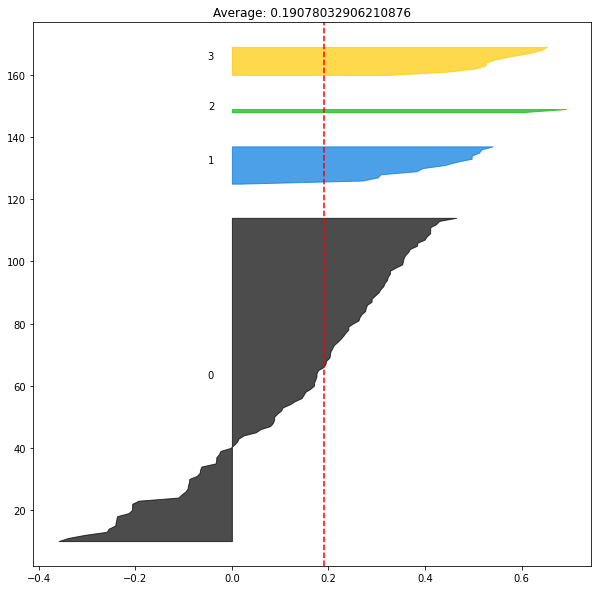

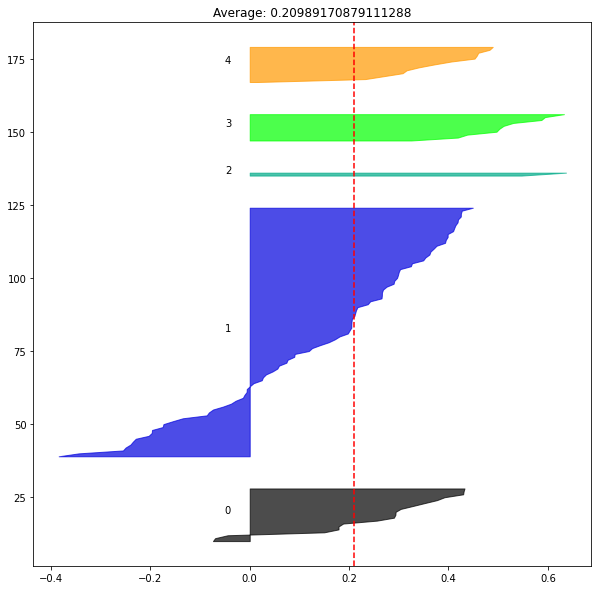

In [ ]:
# 클러스터 수 최적화

for i in n_clusters:
  agglo = AgglomerativeClustering(n_clusters=i, linkage='average')
  agglo.fit(df_fi)  

  model.append('agglo')
  params.append(i)
  sil_value.append(sil_view(agglo, df_fi))

>> ### 4.2.3 Spectral

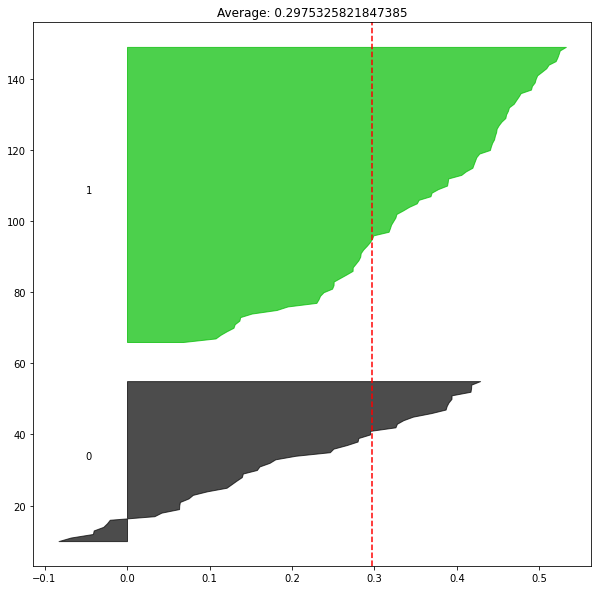

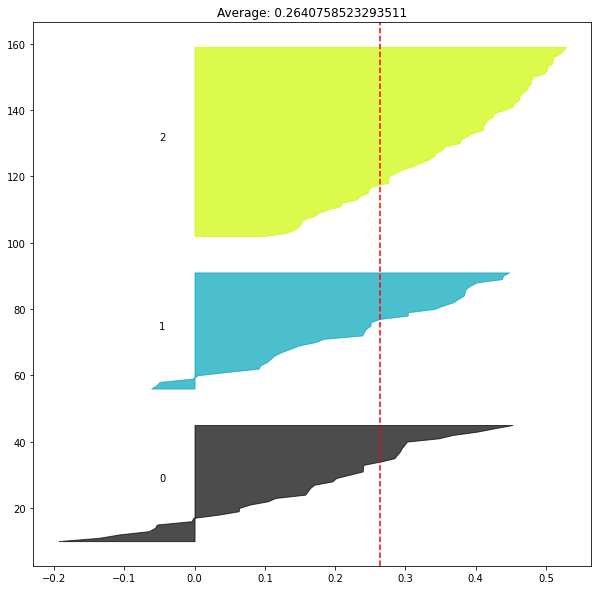

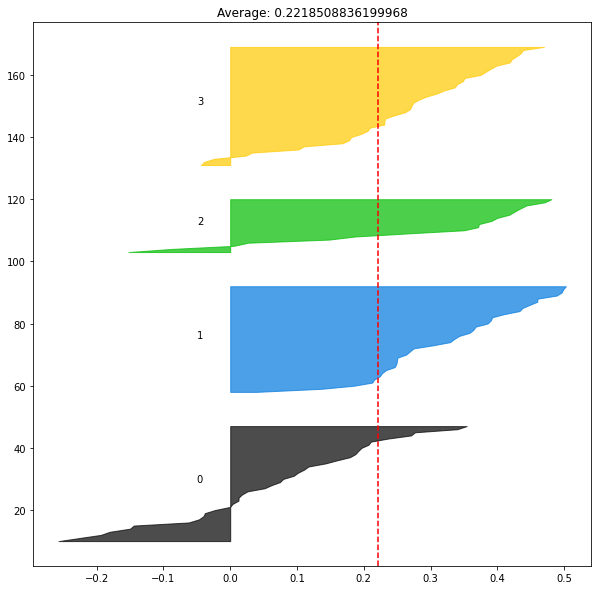

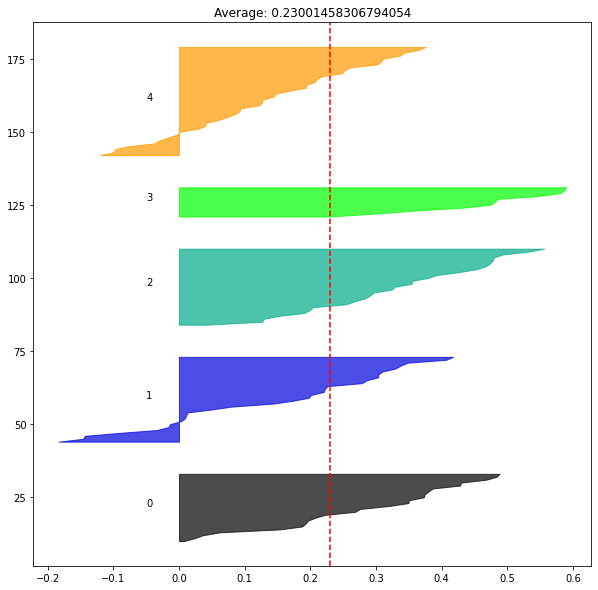

In [ ]:
# 클러스터 수 최적화

for i in n_clusters:
  spec = SpectralClustering(n_clusters=i, assign_labels='discretize',random_state=100)
  spec.fit(df_fi)  

  model.append('spec')
  params.append(i)
  sil_value.append(sil_view(spec, df_fi))

>> ### 4.2.4 MeanShift

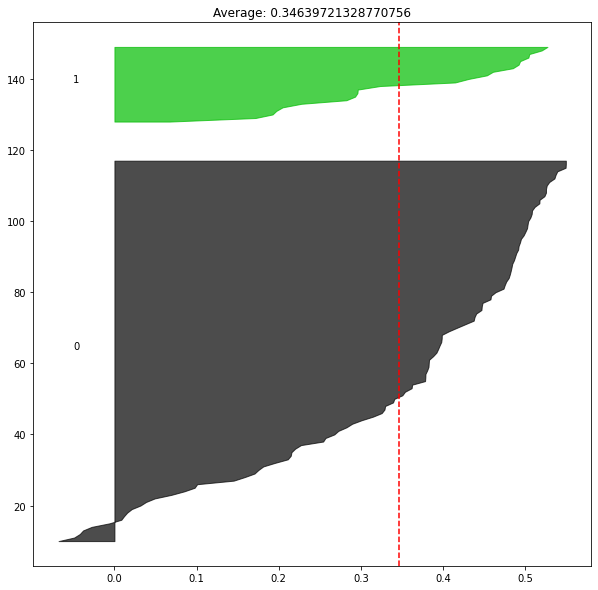

In [ ]:
# bandwidth 수 최적화

bandwidth_ = np.arange(0.25, 0.5, 0.01)

for i in bandwidth_:
  meanshift = MeanShift(bandwidth=i)
  meanshift.fit(df_fi)    

  if max(meanshift.labels_) == 0: continue
  model.append('meanshift')
  params.append(i)
  sil_value.append(sil_view(meanshift, df_fi))

>> ### 4.2.5 Birch

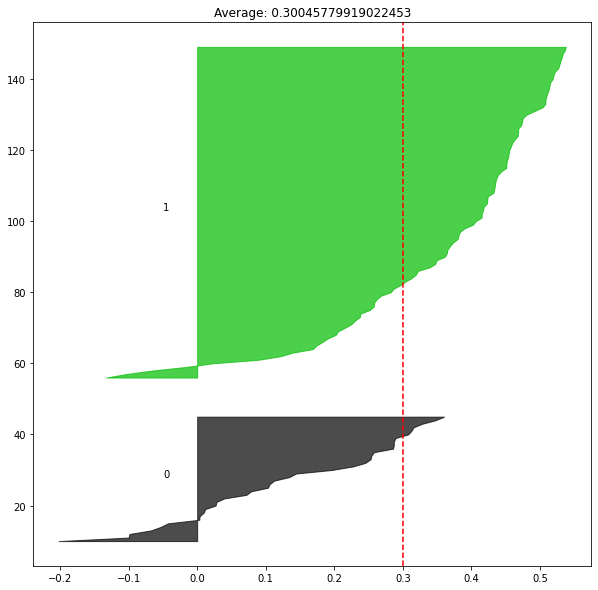

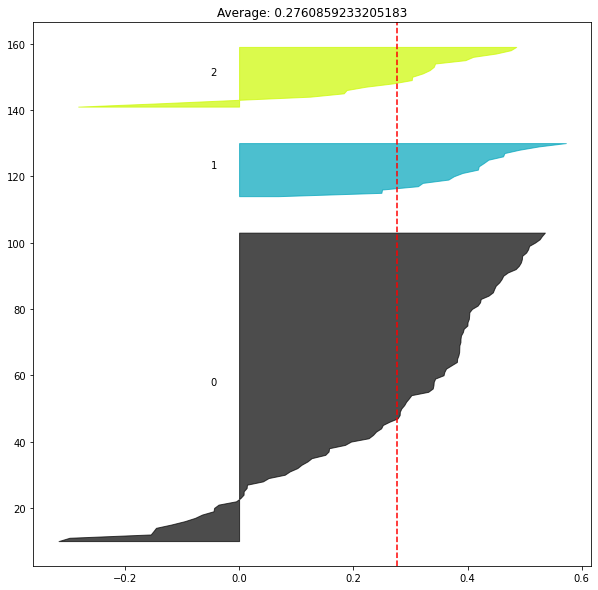

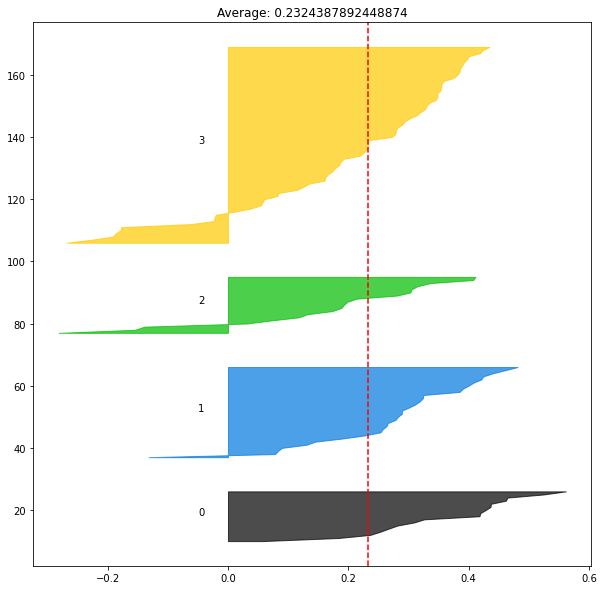

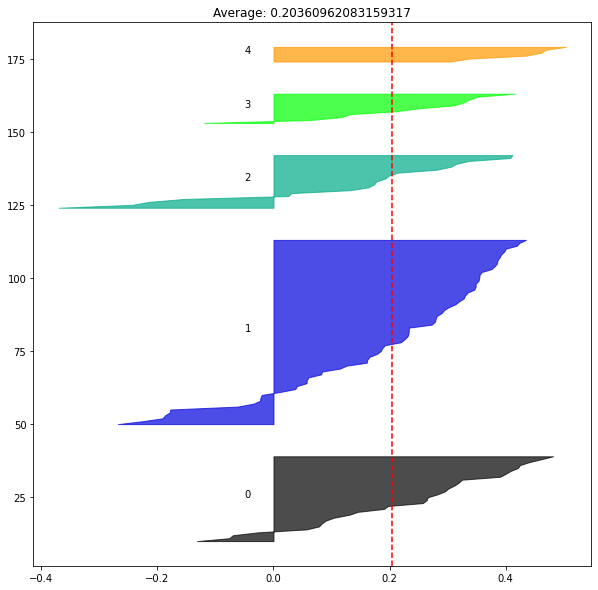

In [ ]:
# 클러스터 수 최적화

for i in n_clusters: 
  birch = Birch(branching_factor = 90, n_clusters =i, threshold = 0.1)
  birch.fit(df_fi)  

  model.append('birch')
  params.append(i)
  sil_value.append(sil_view(birch, df_fi))

> ## 4.3 군집 결론

In [ ]:
# 최대 실루엣 계수를 갖는 모델과 파라미터 출력

clu_result = pd.DataFrame({'model': model, 'params': params, 'sil_value': sil_value})

clu_result.loc[clu_result['sil_value'].idxmax()]

model           agglo
params            2.0
sil_value    0.379932
Name: 4, dtype: object

In [ ]:
# 최대 실루엣 계수를 갖는 모델과 파라미터로 라벨링

kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=500, random_state=0)
kmeans.fit(df_fi)

df_fi['labels'] = kmeans.labels_

In [ ]:
df_fi

,freq_sta,freq_app,amp,labels
0,0.283852,0.471934,0.379494,1
1,0.212653,0.898899,0.725797,1
2,0.315404,0.644534,0.397615,1
3,0.038583,0.413468,0.564753,1
4,0.299395,0.534978,0.400851,1
...,...,...,...,...
125,0.183152,0.832958,0.448907,1
126,0.247981,0.546966,0.417573,1
127,0.303530,0.725438,0.504656,1
128,0.161712,0.549387,0.547441,1


# 5. 등급분류 기준 

> ## 5.1 등급분류 기준 분석

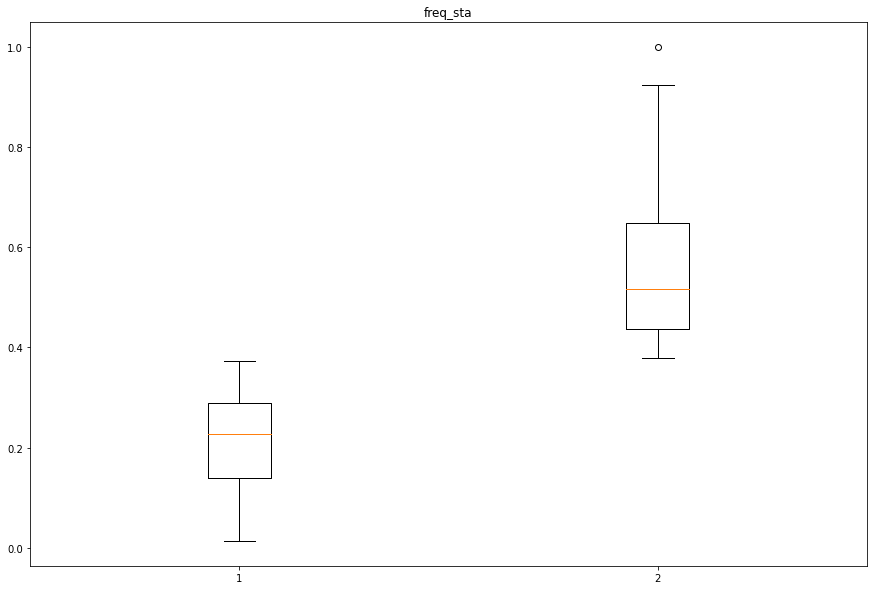

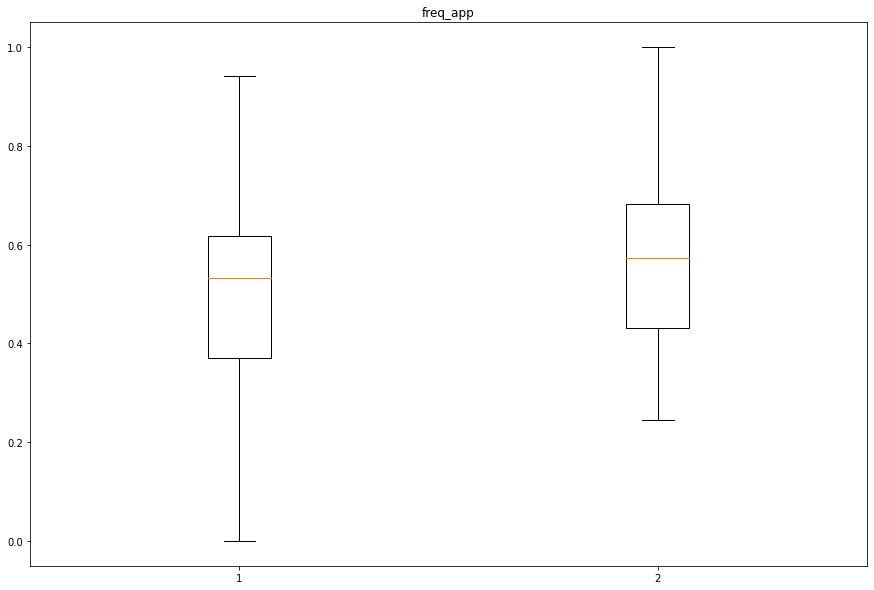

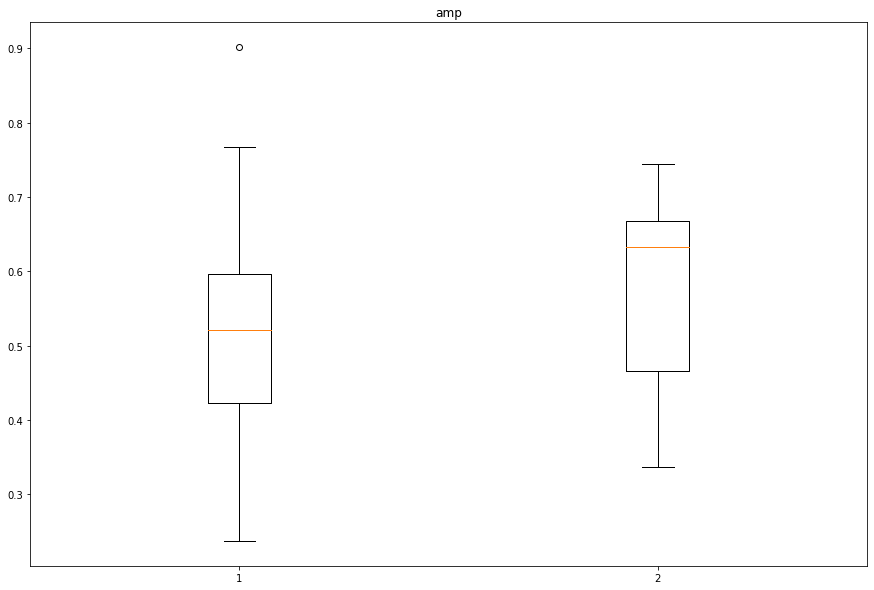

In [ ]:
# 박스 플롯

for i in df_fi.columns: 
  if i == 'labels': continue

  plt.figure(figsize=(15, 10))

  plt.title('{}'.format(i))
  plt.boxplot([df_fi.loc[df_fi['labels']==1, i], df_fi.loc[df_fi['labels']==0, i]], whis=1.5)  

  plt.show()

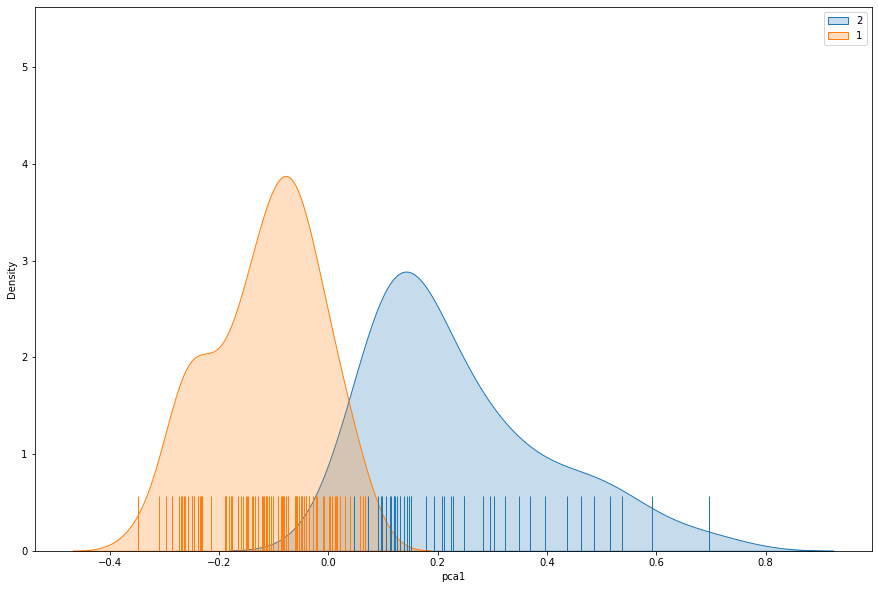

In [ ]:
# 제1 주성분 결과

pca = PCA(n_components=1, random_state=0)
pca_fit = pca.fit_transform(df_fi.drop(['labels'], axis=1))

principalDF = pd.DataFrame(data=pca_fit, columns=['pca1'])

plt.figure(figsize=(15,10))
sns.kdeplot(principalDF.loc[df_fi['labels']==0, 'pca1'], shade=True, label=2)
sns.kdeplot(principalDF.loc[df_fi['labels']==1, 'pca1'], shade=True, label=1)
sns.rugplot(principalDF.loc[df_fi['labels']==0, 'pca1'], height=0.1)
sns.rugplot(principalDF.loc[df_fi['labels']==1, 'pca1'], height=0.1)
plt.legend()

> ## 5.2 등급분류 기준 산정

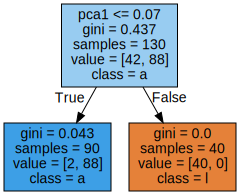

In [ ]:
# DecisionTree를 활용한 기준 산정

dt_clf = DecisionTreeClassifier(random_state=156, min_samples_split=100)
dt_clf.fit(principalDF , df_fi['labels'])
 
export_graphviz(dt_clf, out_file="tree.dot", class_names='labels' , feature_names = principalDF.columns, impurity=True, filled=True)

with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

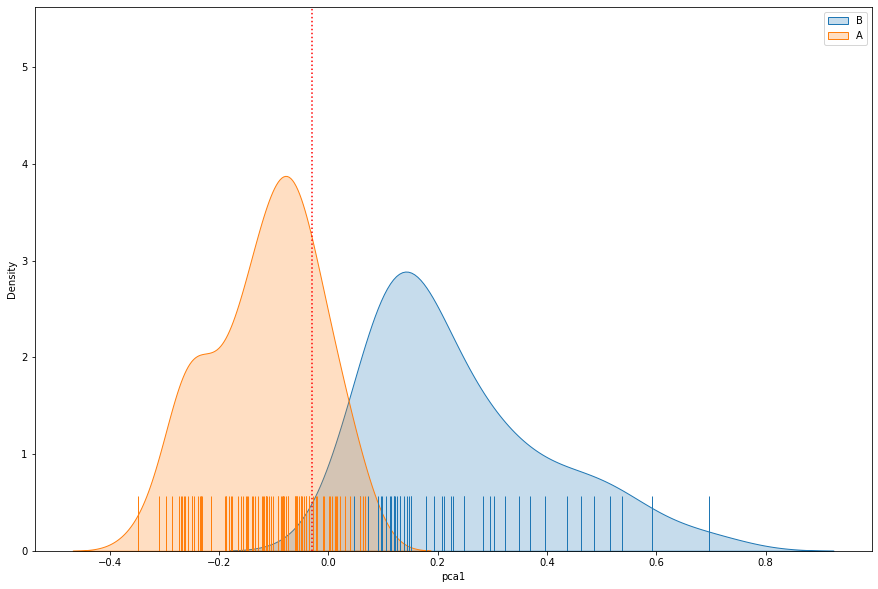

In [ ]:
# 등급기준 시각화

plt.figure(figsize=(15,10))
sns.kdeplot(principalDF.loc[df_fi['labels']==0, 'pca1'], shade=True, label='B')
sns.kdeplot(principalDF.loc[df_fi['labels']==1, 'pca1'], shade=True, label='A')
sns.rugplot(principalDF.loc[df_fi['labels']==0, 'pca1'], height=0.1)
sns.rugplot(principalDF.loc[df_fi['labels']==1, 'pca1'], height=0.1)
plt.axvline(0.07, ls=':', color='r')
plt.legend()

In [ ]:
pca.components_

array([[0.95799504, 0.22329528, 0.17995756]])